# Calculations for the MRM paper

In [42]:
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
import pylab as pl
import numpy as np
from matplotlib import patches
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
import os
from scipy.stats import skew
import itertools

In [58]:
!pip install piq

In [43]:
eps = 1e-7
def calc_adc(high_b_img, low_b_img, bval_high, bval_low):
    if not len(high_b_img.shape) == len(low_b_img.shape):
        low_b_img = np.expand_dims(low_b_img,-1)
    adc = np.zeros((high_b_img.shape[0],
                    high_b_img.shape[1],
                    high_b_img.shape[2],
                    high_b_img.shape[3]*low_b_img.shape[3]))
    acq = 0
    for acq1 in range(high_b_img.shape[3]):
        for acq2 in range(low_b_img.shape[3]):
            adc[:, :, :, acq] = -np.log((high_b_img[:, :, :, acq1]/low_b_img[:, :, :, acq2]))/(bval_high-bval_low)
            acq += 1
    return adc*1000

def calc_mean_adc(high_b_img, S0, bval):
    adc = np.zeros((S0.shape))
    Sb = np.mean(high_b_img, 3)           
    adc = -np.log(Sb/(S0 + eps) + eps)/(bval)
    return adc*1000

eps = 1e-7
def calc_sb_s0(high_b_img, low_b_img):
    if not len(high_b_img.shape) == len(low_b_img.shape):
        low_b_img = np.expand_dims(low_b_img,-1)
    sb_s0 = np.zeros((high_b_img.shape[0],
                    high_b_img.shape[1],
                    high_b_img.shape[2],
                    high_b_img.shape[3]*low_b_img.shape[3]))
    acq = 0
    for acq1 in range(high_b_img.shape[3]):
        for acq2 in range(low_b_img.shape[3]):
            sb_s0[:, :, :, acq] = high_b_img[:, :, :, acq1]/(low_b_img[:, :, :, acq2] + eps)
            acq += 1
    return sb_s0

In [44]:
eps = 1e-7
Sb = 5.4219e+03
S0 = 1.0893e+04
Sb = 14.15
S0 = 26.2
bval = 900
adc = -np.log(Sb/(S0 + eps) + eps)/(bval)
print(adc*1000)

0.6844940059284492


In [45]:
def calc_adc_mean_lms(_case):
    eps = 1e-7
    def lms_adc(inpt):
        sum_xi_yi = sum([x[0]*x[1] for x in inpt])
        sum_yj = sum([x[1] for x in inpt])
        sum_xi_sum_yj = sum([x[0]*sum_yj for x in inpt])
        sum_x2 = sum([x[0]**2 for x in inpt])
        sum_x = sum([x[0] for x in inpt])
        adc = -(len(inpt)*sum_xi_yi - sum_xi_sum_yj)/(len(inpt)*sum_x2 - sum_x**2 )*1000
        return adc
    adc = np.zeros((_case.b0.shape))
    for i in range(_case.b0.shape[0]):
        for j in range(_case.b0.shape[1]):
            _slice = _case.cancer_slice
            #calculate all combinations for a given voxel
            b0 = [[_case.b[0], np.log(_case.b0[i, j, _slice] + eps)]]
            b1 = [[_case.b[1], np.log(np.mean(_case.b1[i, j, _slice,:]) + eps)]]
            b2 = [[_case.b[2], np.log(np.mean(_case.b2[i, j, _slice,:]) + eps)]]
            b3 = [[_case.b[3], np.log(np.mean(_case.b3[i, j, _slice,:]) + eps)]]
            all_bs = [b0, b1, b2, b3]
            combs = list(itertools.product(*all_bs))
            adc[i, j , _slice] = lms_adc(combs[0])
    return adc

In [46]:
def calc_adc_erd_single(_case, temp = 1.5):
    eps = 1e-7
    def calc_mean_adc(Sb, S0, bval):
        adc = np.zeros((S0.shape))        
        adc = -np.log(Sb/(S0 + eps) + eps)/(bval)
        return adc*1000
    mean_image = np.zeros((_case.b0.shape))
    noise_center = _case.noise
    _slice = _case.cancer_slice
    noise_level = np.std(_case.b3[noise_center[0]-3:noise_center[0]+2, 
                                  noise_center[1]-3:noise_center[1]+2,
                                  _slice])/np.sqrt(2-np.pi/2)
    for i in range(_case.b0.shape[0]):
        for j in range(_case.b0.shape[1]):
            x = _case.b3[i, j, _slice, :]
            if np.mean(x)>2*noise_level:
                a = np.exp(x/temp)/np.sum(np.exp(x/temp))
                y = np.sum(a*x)
                mean_image[i,j, _slice] = y
            else:
                mean_image[i,j, _slice] = np.mean(x)

    return calc_mean_adc(mean_image, _case.b0, _case.b[3])

In [47]:
def calc_adc_erd_single2(_case, mul=2, slope=10):
    eps = 1e-7
    def onehot(x):
        _max = np.argmax(x)
        a = np.zeros_like(x)
        a[_max] = 1
        return a
    def calc_mean_adc(Sb, S0, bval):
        adc = np.zeros((S0.shape))        
        adc = -np.log(Sb/(S0 + eps) + eps)/(bval)
        return adc*1000
    mean_image = np.zeros((_case.b0.shape))
    noise_center = _case.noise
    _slice = _case.cancer_slice
    noise_level = np.std(_case.b3[noise_center[0]-3:noise_center[0]+2, 
                                  noise_center[1]-3:noise_center[1]+2,
                                  _slice])/np.sqrt(2-np.pi/2)
    for i in range(_case.b0.shape[0]):
        for j in range(_case.b0.shape[1]):
            x = _case.b3[i, j, _slice, :]
            b_zero = _case.b0[i,j,_slice]
            if np.mean(x)>2*noise_level:
                temp = max(mul*np.exp(-slope*(np.mean(x)/b_zero)), 0.5)
                try:
                    x = x.astype(np.float64)
                    a = np.exp(x/temp)/np.sum(np.exp(x/temp))
                except RuntimeWarning:
                    a = onehot(x)
                    print('here')
                    
                y = np.sum(a*x)
                mean_image[i,j, _slice] = y
            else:
                mean_image[i,j, _slice] = np.mean(x)

    return calc_mean_adc(mean_image, _case.b0, _case.b[3])

In [48]:
def calc_adc_erd_single2(_case, mul=2, slope=10):
    eps = 1e-7
    def onehot(x):
        _max = np.argmax(x)
        a = np.zeros_like(x)
        a[_max] = 1
        return a
    def calc_mean_adc(Sb, S0, bval):
        adc = np.zeros((S0.shape))        
        adc = -np.log(Sb/(S0 + eps) + eps)/(bval)
        return adc*1000
    mean_image = np.zeros((_case.b0.shape))
    noise_center = _case.noise
    _slice = _case.cancer_slice
    noise_level = np.std(_case.b3[noise_center[0]-3:noise_center[0]+2, 
                                  noise_center[1]-3:noise_center[1]+2,
                                  _slice])/np.sqrt(2-np.pi/2)
    for i in range(_case.b0.shape[0]):
        for j in range(_case.b0.shape[1]):
            x = _case.b3[i, j, _slice, :]
            b_zero = _case.b0[i,j,_slice]
            if np.mean(x)>2*noise_level:
                temp = max(mul*np.exp(-slope*(np.mean(x)/b_zero)), 0.5)
                try:
                    x = x.astype(np.float64)
                    a = np.exp(x/temp)/np.sum(np.exp(x/temp))
                except RuntimeWarning:
                    a = onehot(x)
                    print('here')
                    
                y = np.sum(a*x)
                mean_image[i,j, _slice] = y
            else:
                mean_image[i,j, _slice] = np.mean(x)

    return calc_mean_adc(mean_image, _case.b0, _case.b[3])

float64


<BarContainer object of 24 artists>

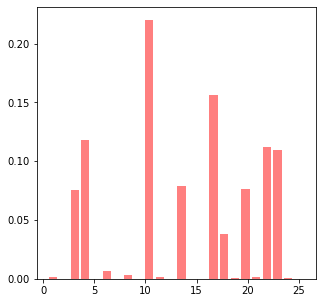

In [49]:
sb_s0 = 2
ss0 = sb_s0 - 0.1*np.random.random(24)
print(ss0.dtype)
fig, ax = plt.subplots(1,1, figsize=(5,5))
slope = 30
temp = 50 + 50*np.tanh(slope*(ss0.max() - 0.4))
a = np.exp(temp*ss0)/np.sum(np.exp(temp*ss0))
ax.bar(np.linspace(1,25,24),a,alpha=0.5, color='red')

#mul = 0.0001
#a = min(mul*np.exp(slope*x.max()), 100)

In [50]:
def calc_adc_erd_multiple(_case, temp = 1.5):
    eps = 1e-7
    def calc_erd(x, noise_level):
        temp = 2 if np.mean(x)>10 else 100
        #temp = 2*np.mean(x)/noise_level
        if np.mean(x)>2*noise_level:
            a = np.exp(x/temp)/np.sum(np.exp(x/temp))
            y = np.sum(a*x)
            return y
        else:
            return np.mean(x)
    def lms_adc(inpt):
        sum_xi_yi = sum([x[0]*x[1] for x in inpt])
        sum_yj = sum([x[1] for x in inpt])
        sum_xi_sum_yj = sum([x[0]*sum_yj for x in inpt])
        sum_x2 = sum([x[0]**2 for x in inpt])
        sum_x = sum([x[0] for x in inpt])
        adc = -(len(inpt)*sum_xi_yi - sum_xi_sum_yj)/(len(inpt)*sum_x2 - sum_x**2 )*1000
        return adc
    
    adc = np.zeros((_case.b0.shape))   
    noise_center = _case.noise
    _slice = _case.cancer_slice
    noise_level_b1 = np.std(_case.b1[noise_center[0]-3:noise_center[0]+2, 
                                  noise_center[1]-3:noise_center[1]+2,
                                  _slice])/np.sqrt(2-np.pi/2)
    noise_level_b2 = np.std(_case.b2[noise_center[0]-3:noise_center[0]+2, 
                                  noise_center[1]-3:noise_center[1]+2,
                                  _slice])/np.sqrt(2-np.pi/2)
    noise_level_b3 = np.std(_case.b3[noise_center[0]-3:noise_center[0]+2, 
                                  noise_center[1]-3:noise_center[1]+2,
                                  _slice])/np.sqrt(2-np.pi/2)
    
    for i in range(_case.b0.shape[0]):
        for j in range(_case.b0.shape[1]):
            _slice = _case.cancer_slice
            #calculate all combinations for a given voxel
            b0 = [[_case.b[0], np.log(_case.b0[i, j, _slice] + eps)]]
            b1 = [[_case.b[1], np.log(calc_erd(_case.b1[i, j, _slice,:], noise_level_b1) + eps)]]
            b2 = [[_case.b[2], np.log(calc_erd(_case.b2[i, j, _slice,:], noise_level_b2) + eps)]]
            b3 = [[_case.b[3], np.log(calc_erd(_case.b3[i, j, _slice,:], noise_level_b3) + eps)]]
            all_bs = [b0, b1, b2, b3]
            combs = list(itertools.product(*all_bs))
            adc[i, j , _slice] = lms_adc(combs[0])
    return adc


In [51]:
class case:
    def __init__(self, pt_id, erc, cancer_loc, contralateral_loc, noise, cancer_slice):
        '''
        class for a case
        pt_id : the patient id
        cancer_loc : cancer location pixel (center of a 3x3 region)
        contralateral_loc : mirror of the cancer location with is non-cancer
        cancer_slice : slice number where the cancer exists
        acquisitions : number of slices per X, Y, Z directions 
        '''
        self.pt_id = pt_id
        self.cancer_loc = cancer_loc
        self.contralateral_loc = contralateral_loc
        self.noise = noise
        self.cancer_slice = cancer_slice
        if erc:
            self.b = (0, 150, 1000, 1500)
        else:
            self.b = (0, 300, 600, 900)
        pt_no = self.pt_id.split('-')[-1]
        file_address = 'C:/Users/Gundogdu/Desktop/University of Chicago/RECONSTRUCTION'
        #filename = os.path.join(file_address, pt_no, 'pat' + pt_no + '_alldata.mat')
        filename = os.path.join(file_address, pt_no, 'no_aver', 'bigImage.mat')
        self.b0 = sio.loadmat(filename)['b0']
        self.b1 = sio.loadmat(filename)['b1']
        self.b2 = sio.loadmat(filename)['b2']
        self.b3 = sio.loadmat(filename)['b3']


In [52]:
cases = []

cases.append(case('18-1681-07', 0, (67, 73), (63, 57), (80,65), 11))
# cases.append(case('18-1681-07', 0, (67, 71), (57, 57), (80,65), 11))
cases.append(case('18-1681-08', 0, (80, 74), (77, 54), (97,65), 10))
#cases.append(case('18-1681-08', 0, (79, 71), (79, 57), (98,65), 10))
cases.append(case('18-1681-09', 0, (62, 64), (56, 70), (76,62), 15))
# cases.append(case('18-1681-09', 0, (63, 63), (56, 66), (75,62), 15))
cases.append(case('18-1681-30', 0, (67, 54), (66, 78), (84,64), 17))
# cases.append(case('18-1681-30', 0, (66, 56), (64, 74), (81,64), 17))
cases.append(case('18-1681-37', 0, (68, 76), (71, 59), (80,67), 10))
# cases.append(case('18-1681-37', 0, (70, 70), (70, 61), (79,67), 10))
cases.append(case('phantom-water', 0, (64, 64), (64, 64), (64,64), 13))
cases.append(case('17-1694-82', 1, (56, 52), (56, 74), (80,60), 16))
cases.append(case('18-1681-41', 1, (69, 57), (69, 69), (86,65), 8))
cases.append(case('18-1694-76', 1, (73, 69), (73, 52), (90,64), 16))
cases.append(case('18-1681-45', 1, (71, 68), (65, 74), (87,62), 13))
cases.append(case('18-1694-78', 1, (62, 76), (63, 53), (78,60), 20))
cases.append(case('17-1694-83', 1, (66, 68), (63, 53), (78,60), 16))
cases.append(case('17-1694-102', 1, (68, 55), (68, 73), (95,64), 8))


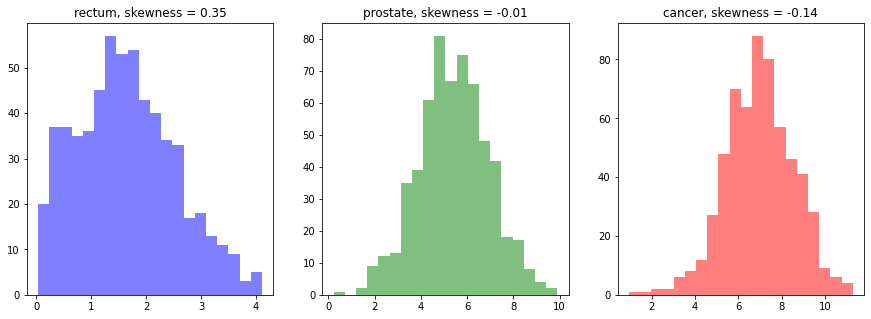

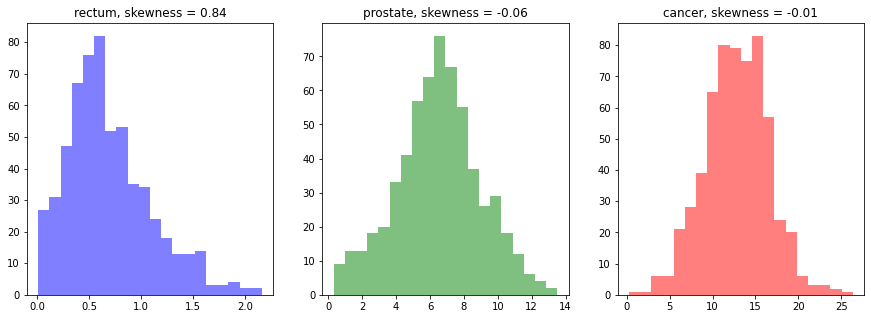

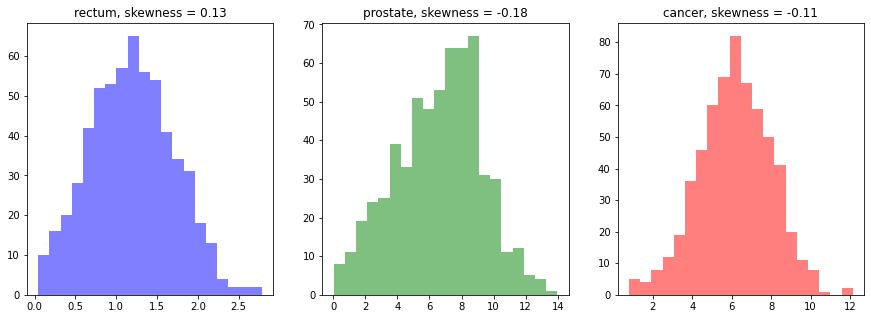

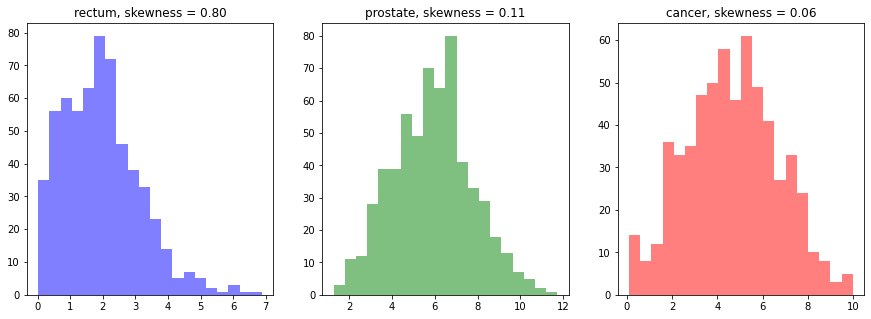

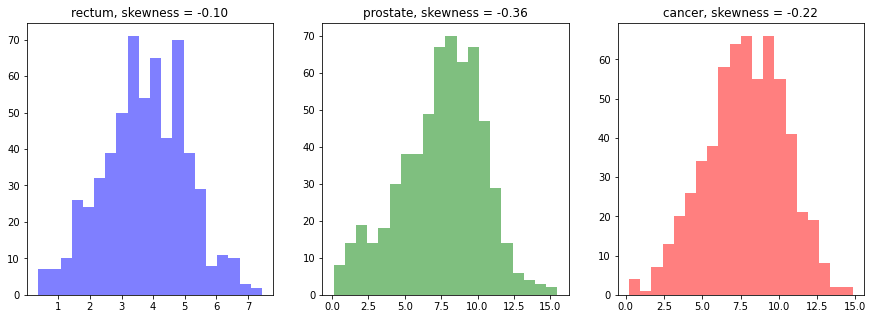

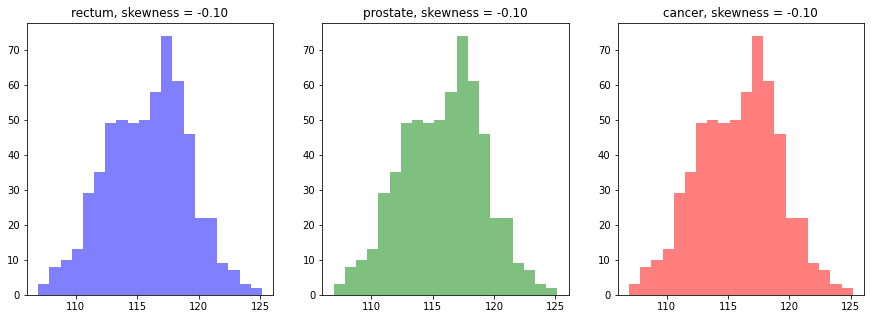

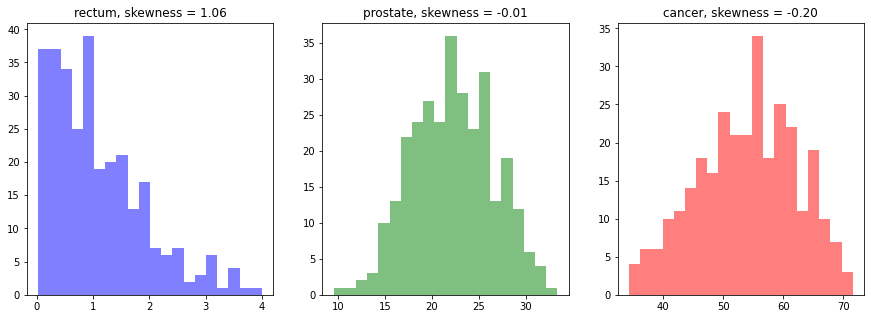

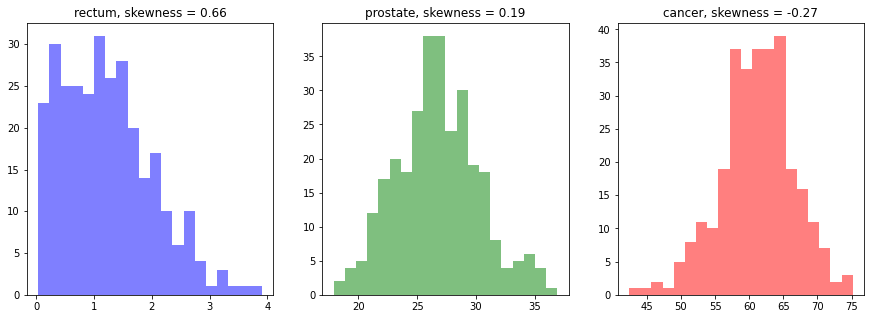

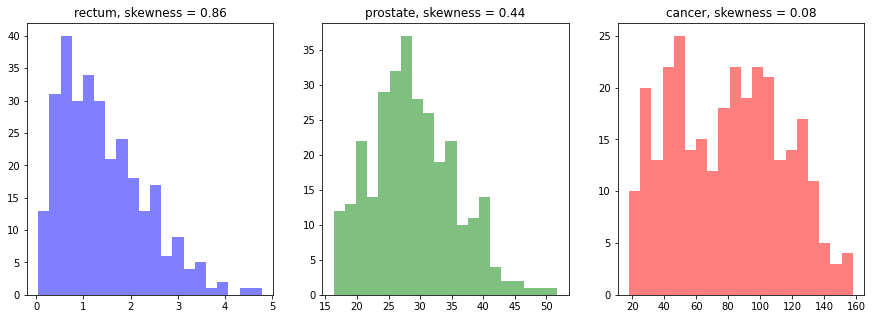

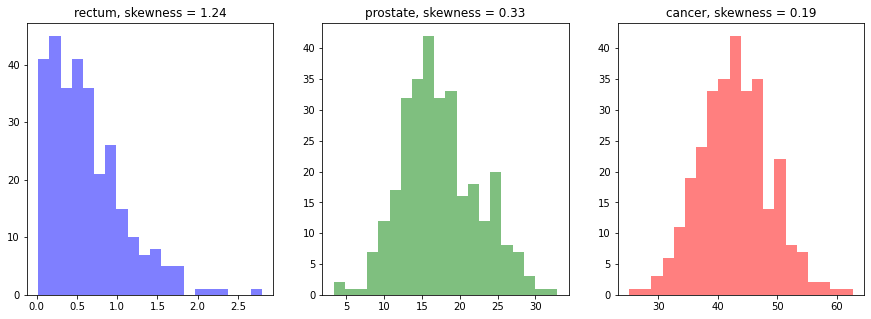

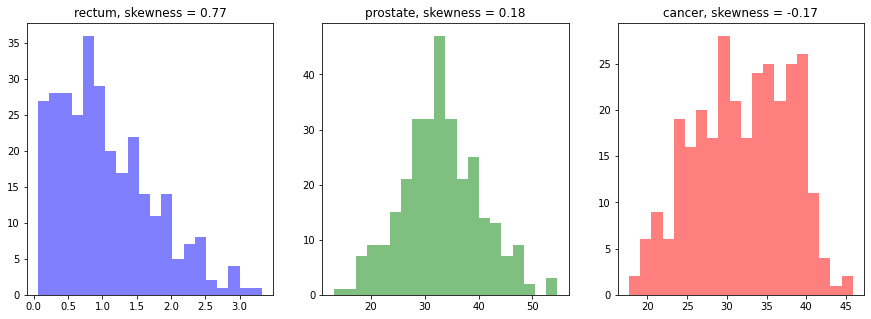

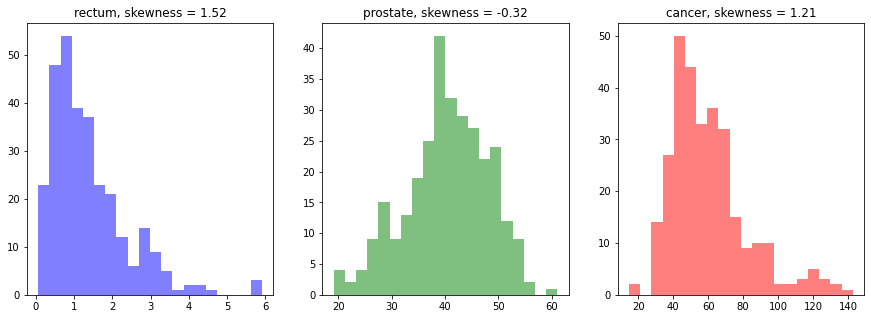

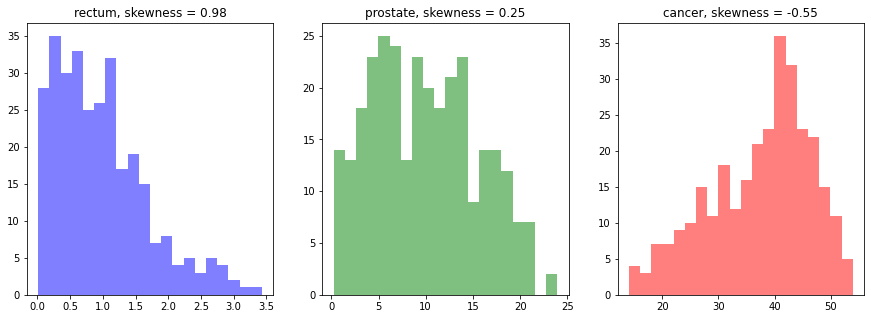

In [53]:
for case_no in range(len(cases)):
    _case = cases[case_no]
    benign_center = _case.contralateral_loc
    noise_center = _case.noise
    center = _case.cancer_loc
    _slice = _case.cancer_slice
    noise = _case.b3[noise_center[0]-2:noise_center[0]+3,
                     noise_center[1]-2:noise_center[1]+3, _slice,: ]
    cancer = _case.b3[center[0]-2:center[0]+3, 
                      center[1]-2:center[1]+3, _slice,: ]
    benign = _case.b3[benign_center[0]-2:benign_center[0]+3, 
                      benign_center[1]-2:benign_center[1]+3, _slice,: ]

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    #bins = np.linspace(0, 50, 50)
    ax[0].hist(noise.flatten(), bins=20, alpha=0.5, label='cancer ROI', color='blue')
    ax[0].set_title(f'rectum, skewness = {skew(noise.flatten()):.2f}')
    ax[1].hist(benign.flatten(), bins=20,alpha=0.5, label='cancer ROI', color='green')
    ax[1].set_title(f'prostate, skewness = {skew(benign.flatten()):.2f}')
    ax[2].hist(cancer.flatten(),bins=20, alpha=0.5, label='cancer ROI', color='red')
    ax[2].set_title(f'cancer, skewness = {skew(cancer.flatten()):.2f}')
#         ax.hist(benign_nerc, bins, alpha=0.5, label='benign ROI', color='green')
    #ax.imshow(SD_img, vmin=noise_range)


In [54]:
def calc_adc_erd_single3(_case):
    c = 1.1 if _case.b[3]==1500 else 1.4
    eps = 1e-7
    def onehot(x):
        _max = np.argmax(x)
        a = np.zeros_like(x)
        a[_max] = 1
        return a
    def calc_mean_adc(Sb, S0, bval):
        adc = np.zeros((S0.shape))        
        adc = -np.log(Sb/(S0 + eps) + eps)/(bval)
        return adc*1000
    mean_image = np.zeros((_case.b0.shape))
    noise_center = _case.noise
    _slice = _case.cancer_slice
    noise_level = np.std(_case.b3[noise_center[0]-3:noise_center[0]+2, 
                                  noise_center[1]-3:noise_center[1]+2,
                                  _slice])/np.sqrt(2-np.pi/2)
    for i in range(_case.b0.shape[0]):
        for j in range(_case.b0.shape[1]):
            x = _case.b3[i, j, _slice, :]
            b_zero = _case.b0[i,j,_slice]
            adc = -1000*np.log(np.mean(x)/b_zero)/_case.b[3]
            if np.mean(x)>2*noise_level:
                #temp = max(mul*np.exp(slope*(adc-2)), 0.5)
                temp = 2*np.tanh(10*(adc-c))+2.5
                try:
                    x = x.astype(np.float64)
                    a = np.exp(x/temp)/np.sum(np.exp(x/temp))
                except RuntimeWarning:
                    a = onehot(x)
                    print('here')
                    
                y = np.sum(a*x)
                mean_image[i,j, _slice] = y
            else:
                mean_image[i,j, _slice] = np.mean(x)

    return calc_mean_adc(mean_image, _case.b0, _case.b[3])

Text(0, 0.5, '$\\tau$ parameter')

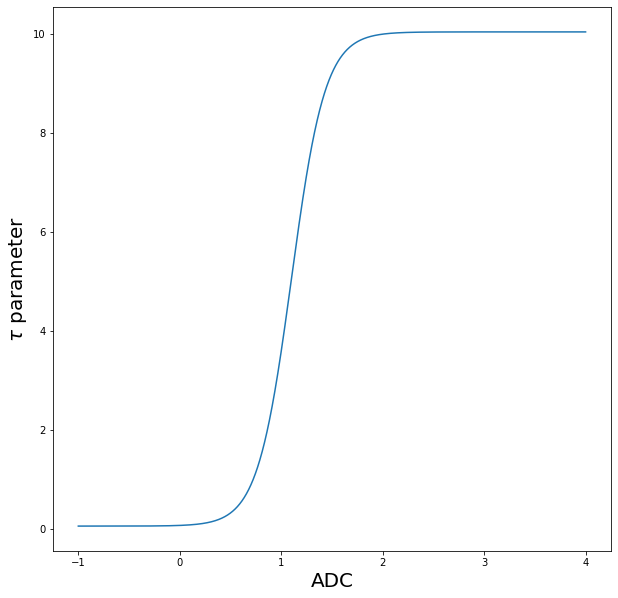

In [55]:
import numpy as np
import matplotlib.pyplot as plt

adc = np.arange(-1,4,0.001)
c = 1.1
temp = 5*np.tanh(3*(adc-c))+5.05
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(adc, temp)
ax.set_xlabel('ADC', fontsize=20)

ax.set_ylabel(r'$\tau$ parameter', fontsize=20)
#ax.set_yticks([])

In [6]:
adc

array([0])

18-1681-07, Mean ADC, cancer=1.01,   benign=1.51,   CR=1.49
18-1681-07, ERD, cancer=0.68,   benign=1.43,   CR=2.11
18-1681-08, Mean ADC, cancer=0.73,   benign=1.92,   CR=2.62
18-1681-08, ERD, cancer=0.34,   benign=1.85,   CR=5.49
18-1681-09, Mean ADC, cancer=1.25,   benign=1.91,   CR=1.52
18-1681-09, ERD, cancer=1.06,   benign=1.89,   CR=1.77
18-1681-30, Mean ADC, cancer=1.04,   benign=1.45,   CR=1.39
18-1681-30, ERD, cancer=0.48,   benign=1.33,   CR=2.74
18-1681-37, Mean ADC, cancer=0.91,   benign=1.79,   CR=1.96
18-1681-37, ERD, cancer=0.56,   benign=1.75,   CR=3.14
phantom-water, Mean ADC, cancer=1.94,   benign=1.94,   CR=1.00
phantom-water, ERD, cancer=1.94,   benign=1.94,   CR=1.00
17-1694-82, Mean ADC, cancer=0.50,   benign=1.10,   CR=2.21
17-1694-82, ERD, cancer=0.41,   benign=1.09,   CR=2.62
18-1681-41, Mean ADC, cancer=0.56,   benign=1.25,   CR=2.22
18-1681-41, ERD, cancer=0.50,   benign=1.25,   CR=2.48
18-1694-76, Mean ADC, cancer=0.47,   benign=1.39,   CR=2.97
18-1694-76, ER

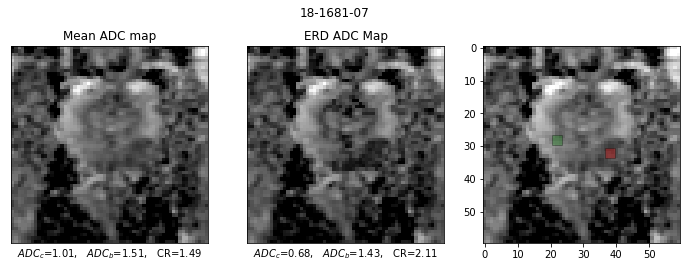

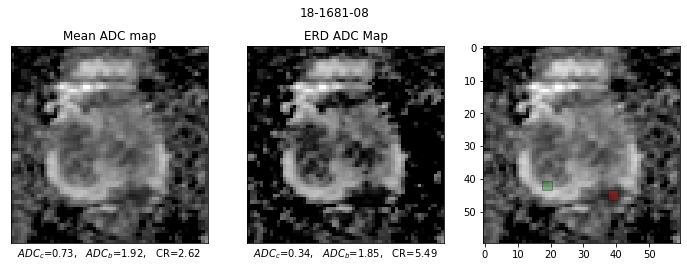

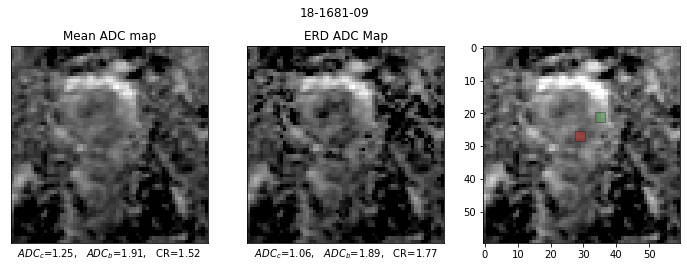

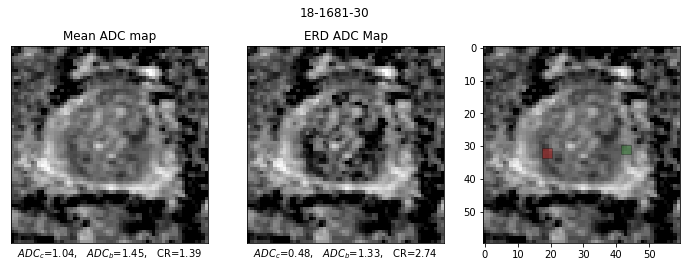

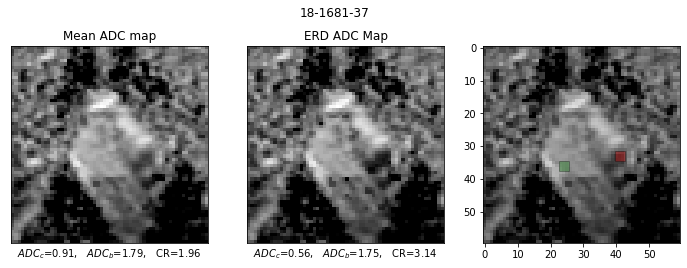

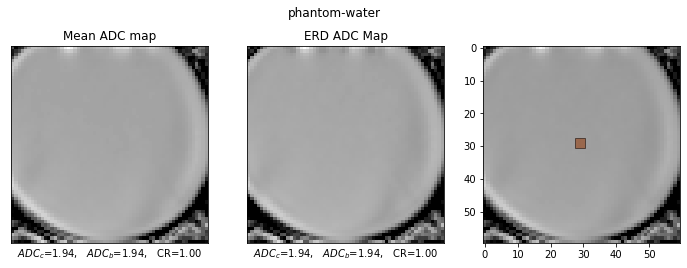

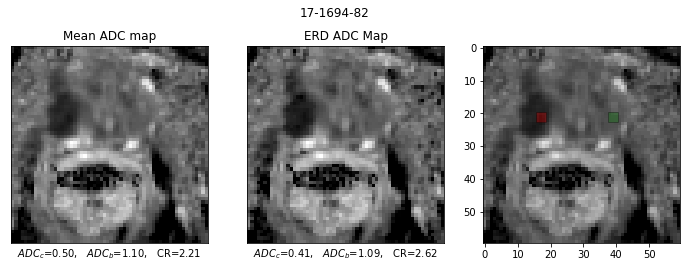

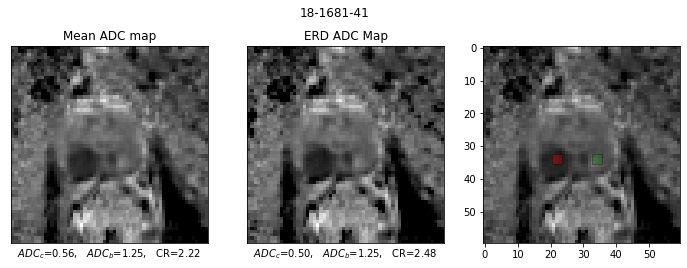

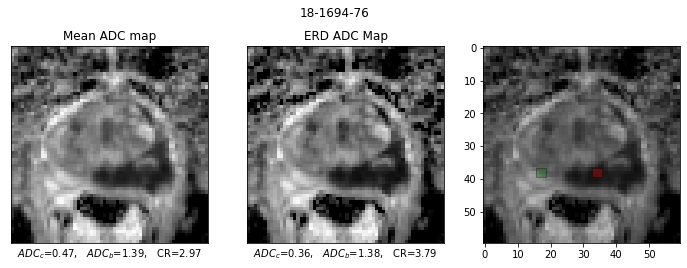

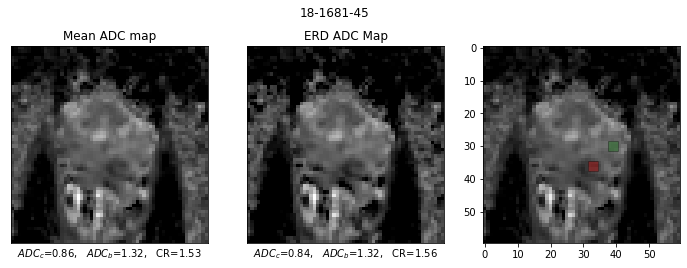

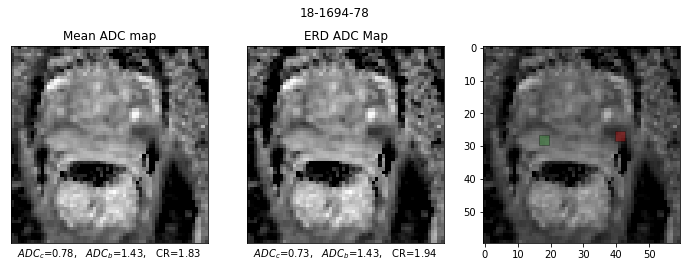

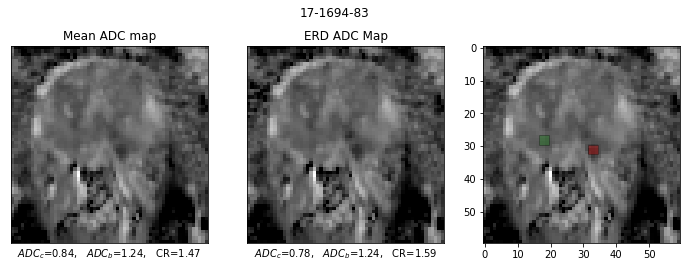

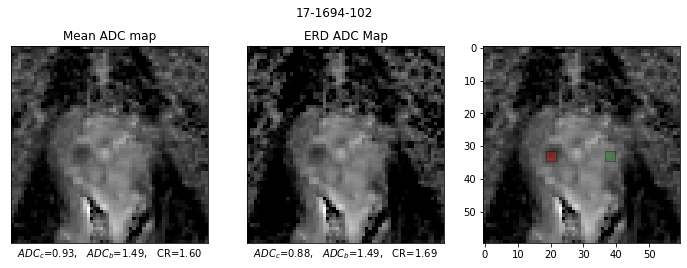

In [56]:
ROI_start = 35
ROI_range = 95
pre = []
post = []
for case_no in range(len(cases)):
    _case = cases[case_no]
    adc1 = calc_mean_adc(_case.b3, _case.b0, _case.b[3])
    #adc1 = calc_adc_mean_lms(_case)
    benign_center = _case.contralateral_loc
    noise_center = _case.noise
    center = _case.cancer_loc
    _slice = _case.cancer_slice
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    fig.suptitle(_case.pt_id)
    adc_c = 'ADC_c'
    adc_b = 'ADC_b'
    noise = np.std(adc1[noise_center[0]-3:noise_center[0]+2, noise_center[1]-3:noise_center[1]+2, _slice])
    cancer_all = adc1[center[0]-1:center[0]+2, center[1]-1:center[1]+2, _slice]
    cancer_mean = np.mean(adc1[center[0]-1:center[0]+2, center[1]-1:center[1]+2, _slice])
    ben_mean = np.mean(adc1[benign_center[0]-1:benign_center[0]+2, benign_center[1]-1:benign_center[1]+2, _slice])
    if not case_no == 5:
        pre += [round(ben_mean/x,2) for x in cancer_all.flatten()]
    print(f'{_case.pt_id}, Mean ADC, cancer={cancer_mean:.2f},   benign={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}')
    ax[0].imshow(adc1[ROI_start:ROI_range,ROI_start:ROI_range,_slice], cmap='gray',vmin=0.2)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel(f'${{{adc_c}}}$={cancer_mean:.2f},   ${{{adc_b}}}$={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}')
    ax[0].set_title(f'Mean ADC map')


    adc4 = calc_adc_erd_single2(_case, 1000, 20)
    #adc4 = calc_adc_erd_single3(_case)
          
    noise = np.std(adc4[noise_center[0]-3:noise_center[0]+2, noise_center[1]-3:noise_center[1]+2, _slice])
    cancer_all = adc4[center[0]-1:center[0]+2, center[1]-1:center[1]+2, _slice]
    cancer_mean = np.mean(adc4[center[0]-1:center[0]+2, center[1]-1:center[1]+2, _slice])
    ben_mean = np.mean(adc4[benign_center[0]-1:benign_center[0]+2, benign_center[1]-1:benign_center[1]+2, _slice])
    if not case_no == 5:
        post += [round(ben_mean/x,2) for x in cancer_all.flatten()]
    ax[1].imshow(adc4[ROI_start:ROI_range,ROI_start:ROI_range,_slice], cmap='gray',vmin=0.2);
    ax[1].set_xticks([]);
    ax[1].set_yticks([]);
    
    ax[1].set_xlabel(f'${{{adc_c}}}$={cancer_mean:.2f},   ${{{adc_b}}}$={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}');
    ax[1].set_title('ERD ADC Map');
    print(f'{_case.pt_id}, ERD, cancer={cancer_mean:.2f},   benign={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}')
    
    measured = [( benign_center[0] , benign_center[1]), ( center[0], center[1])]
    colors = ['green', 'red']
    for i in range(2):
        x_start = measured[i][1] - 0.5 - ROI_start
        y_start = measured[i][0] - 0.5 - ROI_start
        rect = patches.Rectangle((x_start-1, y_start-1), 3, 3, edgecolor='black', facecolor=colors[i], alpha=0.3)
        ax[2].add_patch(rect)
    ax[2].imshow(adc1[ROI_start:ROI_range,ROI_start:ROI_range,_slice], cmap='gray',vmin=0.2, vmax=3)

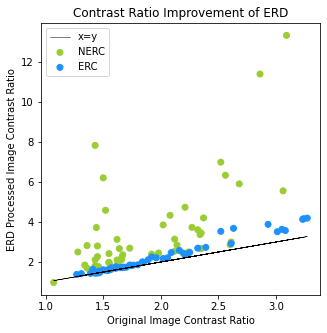

In [57]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
c = pre
c1 = ['yellowgreen' for x in pre[:len(c)//2]]
c2 = ['dodgerblue' for x in pre[len(c)//2:]]
#c[len(c)//2:] = ['dodgerblue']*(len(c)//2)
ax.scatter(pre[:len(c)//2],post[:len(c)//2],c=c1)
ax.scatter(pre[len(c)//2:],post[len(c)//2:],c=c2)
ax.plot(pre,pre,color='black',linewidth=0.5)
ax.set_xlabel('Original Image Contrast Ratio')
ax.set_ylabel('ERD Processed Image Contrast Ratio')
ax.set_title('Contrast Ratio Improvement of ERD')
ax.legend(['x=y', 'NERC', 'ERC'])

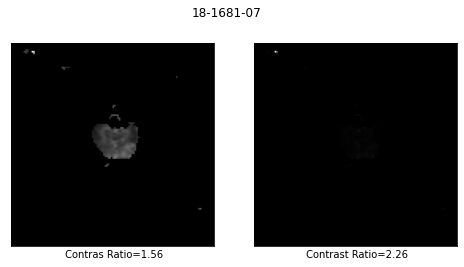

In [31]:
ROI_start = 40
ROI_range = 90
case_no=0
_case = cases[case_no]
sbs0 = calc_sb_s0(_case.b3, _case.b0)
benign_center = _case.contralateral_loc
noise_center = _case.noise
center = _case.cancer_loc
_slice = _case.cancer_slice
noise = _case.b3[noise_center[0]-1:noise_center[0]+2, noise_center[1]-1:noise_center[1]+2, _slice,: ]
noise_range = np.std(noise)/np.sqrt(2-np.pi/2)
for i in range(_case.b3.shape[0]):
    for j in range(_case.b3.shape[1]):
        if np.mean(_case.b3[i,j, _slice,:]) < 2.5*noise_range:
            sbs0[i,j,_slice,:] = 0
temp = 0.4
x = sbs0[:, :, _slice,:]
a = np.exp(x/temp)/np.sum(np.exp(x/temp))
y = np.sum(a*x,-1)

#adc1 = calc_adc_mean_lms(_case)

fig, ax = plt.subplots(1,2, figsize=(8,4))
fig.suptitle(_case.pt_id)
ax[0].imshow(np.mean(sbs0[:,:,_slice],-1), cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(y, cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])

cancer_mean = np.mean(sbs0[center[0]-1:center[0]+2, center[1]-1:center[1]+2, _slice])
ben_mean = np.mean(sbs0[benign_center[0]-1:benign_center[0]+2, benign_center[1]-1:benign_center[1]+2, _slice])
cancer_y = np.mean(y[center[0]-1:center[0]+2, center[1]-1:center[1]+2])
ben_y = np.mean(y[benign_center[0]-1:benign_center[0]+2, benign_center[1]-1:benign_center[1]+2])

ax[0].set_xlabel(f' Contras Ratio={(cancer_mean/ben_mean):.2f}');  
ax[1].set_xlabel(f' Contrast Ratio={(cancer_y/ben_y):.2f}');  
    

In [32]:
for case_no in range(11):
    print(case_no)
    _case = cases[case_no]
    sbs0 = calc_sb_s0(_case.b3, _case.b0)
    sbs0 = -np.log(sbs0)*1000/_case.b[3]
    benign_center = _case.contralateral_loc
    center = _case.cancer_loc
    _slice = _case.cancer_slice
    all_ = sbs0[:, :, _slice,:].flatten()
    cancer = sbs0[center[0]-1:center[0]+2, center[1]-1:center[1]+2, _slice,:].flatten()
    healthy = sbs0[benign_center[0]-1:benign_center[0]+2, benign_center[1]-1:benign_center[1]+2, _slice,:].flatten()
    #print(healthy.min(), healthy.max())
    #print(cancer.min(), cancer.max())
    print(all_.min(), all_.max())



0
-3.6309310695559294 10.691115069513014
1
-4.68638170601406 8.671012748197608
2
-3.615001381347025 12.547768239552306
3
-4.4579686811817325 9.910909059567532
4
-3.916687384904814 10.402404109342882
5
-4.739569042731578 8.601036192712298
6
-2.4898977780333964 7.2786490175376395
7
-2.737922664428006 6.107447450365235
8
-2.3287938628312395 5.966494983599852
9
-2.6084307551847807 5.377572382730565
10
-2.596027450555436 5.546844045223268


### ROI and Triangle Plots

In [ ]:
ROI_start = 35
ROI_range = 95
for case_no in range(len(cases)):
    _case = cases[case_no]
    benign_center = _case.contralateral_loc
    noise_center = _case.noise
    center = _case.cancer_loc
    _slice = _case.cancer_slice
    img = np.mean(_case.b3[ROI_start:ROI_range, ROI_start:ROI_range, _slice, :], 2)
    figure, ax = plt.subplots(1, figsize=(6,6))
    colors = [["coral", "lime", "skyblue"],["green", "red", "blue"],["orange", "violet", "peru"]]
    for i in range(-1,2):
        for j in range(-1,2):
            x_start = center[1]-1.5 + i*3 - ROI_start
            y_start = center[0]-1.5 + j*3 - ROI_start
            #rect = patches.Rectangle((x_start+1, y_start+1), 1, 1, edgecolor='black', facecolor='none', alpha=1.0, lw = 2)
            rect2 = patches.Rectangle((x_start, y_start), 3, 3, edgecolor='none', facecolor=colors[j+1][i+1], alpha=0.3)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            #ax.add_patch(rect)
            ax.add_patch(rect2)
    noise = _case.b3[noise_center[0]-1:noise_center[0]+2, noise_center[1]-1:noise_center[1]+2, _slice,: ]
    noise_range = np.std(noise)/np.sqrt(2-np.pi/2)
    figure, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(img, cmap='gray')
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    labels = ['X', 'Y', 'Z','X']
    labels2 = [' ', ' ', ' ',' ']
    num_vars = 3
    fig, ax = plt.subplots(3, 3, figsize=(16, 16),subplot_kw=dict(polar=True))
    nec = 8 if case_no<5 else 4
    for r in range(-1,2):
        for c in range(-1,2):
            x_start = center[0]-1 + r*3
            y_start = center[1]-1 + c*3
            ROI = _case.b3[x_start : x_start + 3, y_start : y_start + 3, _slice,:]
            x_range = np.std(ROI[:, :, :nec])# - np.amin(ROI[:, :, :nec], 2)
            y_range = np.std(ROI[:, :, nec:2*nec])# - np.amin(ROI[:, :, nec:2*nec], 2)
            z_range = np.std(ROI[:, :, 2*nec:])# - np.amin(ROI[:, :, 2*nec:], 2)
            #ranges = [x_range.mean(),  y_range.mean(), z_range.mean()]
            ranges = [x_range,  y_range, z_range]
            values = ranges

            angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
            values += values[:1]
            angles += angles[:1]
            ax[r + 1 ,c + 1].set_ylim(0, 10)
            ax[r +1 , c + 1].plot(angles, values, color=colors[r + 1][c + 1], linewidth=1)
            ax[r +1 , c + 1].fill(angles, values, color=colors[r + 1][c + 1], alpha=0.25)
            if not r and not c:
                ax[r +1 , c + 1].set_thetagrids(np.degrees(angles), labels)     
            else :
                ax[r +1 , c + 1].set_thetagrids(np.degrees(angles), labels2)
                ax[r +1 , c + 1].set_yticklabels([])
            ax[r +1 , c + 1].set_theta_offset(np.pi / 2)
            ax[r +1 , c + 1].set_theta_direction(-1)
            for label, angle in zip(ax[r +1 , c + 1].get_xticklabels(), angles):
                label.set_horizontalalignment('center')
                label.set_verticalalignment('bottom')
                if angle in (0, np.pi):
                    label.set_horizontalalignment('center')
                    label.set_verticalalignment('top')
            ax[r +1 , c + 1].set_rlabel_position(180 / num_vars)
            ax[r +1 , c + 1].tick_params(colors='#222222')
            circle2 = pl.Circle((0, 0), noise_range, transform=ax[r+1,c+1].transData._b, color="gray", alpha=1, fill=True)
            #ax[r,c].add_artist(circle)
            ax[r +1 , c + 1].add_artist(circle2)
            # Make the y-axis (0-100) labels smaller.
            ax[r +1 , c + 1].tick_params(axis='y', labelsize=12)
            # Change the color of the circular gridlines.
            #ax.grid(color='#AAAAAA')
            # Change the color of the outermost gridline (the spine).
            #ax.spines['polar'].set_color('#222222')
            # Change the background color inside the circle itself.

            ax[r +1 , c + 1].set_facecolor('#FAFAFA')

In [ ]:
def calc_adc_lms(_case):
    eps = 1e-7
    def lms_adc(inpt):
        sum_xi_yi = sum([x[0]*x[1] for x in inpt])
        sum_yj = sum([x[1] for x in inpt])
        sum_xi_sum_yj = sum([x[0]*sum_yj for x in inpt])
        sum_x2 = sum([x[0]**2 for x in inpt])
        sum_x = sum([x[0] for x in inpt])
        adc = -(len(inpt)*sum_xi_yi - sum_xi_sum_yj)/(len(inpt)*sum_x2 - sum_x**2 )*1000
        return adc
    adc = np.zeros((_case.b0.shape[0], _case.b0.shape[1],_case.b1.shape[3]*_case.b2.shape[3]*_case.b3.shape[3]))
    for i in range(_case.b0.shape[0]):
        for j in range(_case.b0.shape[1]):
            _slice = _case.cancer_slice
            #calculate all combinations for a given voxel
            b0 = [[_case.b[0], np.log(_case.b0[i, j, _slice] + eps)]]
            b1 = [[_case.b[1], np.log(x + eps)] for x in _case.b1[i, j, _slice,:]]
            b2 = [[_case.b[2], np.log(x + eps)] for x in _case.b2[i, j, _slice,:]]
            b3 = [[_case.b[3], np.log(x + eps)] for x in _case.b3[i, j, _slice,:]]
            all_bs = [b0, b1, b2, b3]
            combs = list(itertools.product(*all_bs))
            adc[i, j] = [lms_adc(x) for x in combs]
    return adc

In [ ]:
from scipy.stats import skew, kurtosis
ROI_start = 35
ROI_range = 95
fig_size = (10,10)
ROI_cancer_nerc = np.zeros((6, 3, 3, 648))
ROI_benign_nerc = np.zeros((6, 3, 3, 648))
ROI_cancer_erc = np.zeros((5, 3, 3, 108))
ROI_benign_erc = np.zeros((5, 3, 3, 108))

ROI_cancer_center_nerc = np.zeros((6, 648))
ROI_benign_center_nerc = np.zeros((6, 648))
ROI_cancer_center_erc = np.zeros((5, 108))
ROI_benign_center_erc = np.zeros((5, 108))

case_no = 0 #for case_no in range(len(cases)):
print(case_no)
_case = cases[case_no]
adc = calc_adc_lms(_case)
adc1 = calc_mean_adc(_case.b3, _case.b0, _case.b[3])
benign_center = _case.contralateral_loc
noise_center = _case.noise
center = _case.cancer_loc
_slice = _case.cancer_slice
fig, ax = plt.subplots(1,1, figsize=(5,5))
img = adc1[ROI_start:ROI_range, ROI_start:ROI_range, _slice]
measured = [( benign_center[0] , benign_center[1]), ( center[0], center[1])]
colors = ['green', 'red']
for i in range(2):
    x_start = measured[i][1] - 0.5 - ROI_start
    y_start = measured[i][0] - 0.5 - ROI_start
    rect = patches.Rectangle((x_start-1, y_start-1), 3, 3, edgecolor='black', facecolor=colors[i], alpha=0.3)
    ax.add_patch(rect)
ax.imshow(img, cmap='gray')
ax.axis('off')
if case_no < 6:
    ROI_cancer_nerc[case_no, :, :, :] = np.asarray(adc[center[0] - 1: center[0] + 2,
                                                       center[1] - 1 : center[1] + 2, :])
    ROI_benign_nerc[case_no, :, :, :] = np.asarray(adc[benign_center[0] - 1: benign_center[0] + 2, 
                                                         benign_center[1] - 1 : benign_center[1] + 2, :])

    ROI_cancer_center_nerc[case_no, :] = np.asarray(adc[center[0], center[1] , :])
    ROI_benign_center_nerc[case_no, :] = np.asarray(adc[benign_center[0], benign_center[1], :])

    cancer_nerc = [x for x in ROI_cancer_nerc[case_no, :].flatten() if x<3]
    benign_nerc = [x for x in ROI_benign_nerc[case_no, :].flatten() if x<3]
    cancer_center_nerc = [x for x in ROI_cancer_center_nerc[case_no, :].flatten() if x<3]
    benign_center_nerc = [x for x in ROI_benign_center_nerc[case_no, :].flatten() if x<3]
    bins = np.linspace(0, 5, 50)
    th = 1.45 if _case.b ==900 else 0.9
    fig, ax = plt.subplots(1,1, figsize=fig_size)
    ax.hist(cancer_nerc, bins, alpha=0.5, label='cancer ROI', color='red')
    ax.hist(benign_nerc, bins, alpha=0.5, label='healthy ROI', color='green')
    ax.legend(loc='upper right', prop={'size': 20})
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_ylabel('counts', fontsize=20)
    ax.set_xlabel('ADC', fontsize=20)
    labels = ['cancer ROI', 'cancer center', 'healthy ROI', 'healthy center']
    fig, ax = plt.subplots(1,1, figsize=fig_size)

    b=ax.violinplot([cancer_nerc, cancer_center_nerc, benign_nerc, benign_center_nerc])
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelsize=20)
    ax.set_ylabel('ADC', fontsize=20)
    for i, pc in enumerate(b['bodies']):
        pc.set_edgecolor('black')
        if i<2:
            pc.set_facecolor('red')
        else:
            pc.set_facecolor('green')
    b['cbars'].set_color('black')
    b['cbars'].set_linewidth(1)
    b['cmaxes'].set_color('black')
    b['cmaxes'].set_linewidth(1)
    b['cmins'].set_color('black')
    b['cmins'].set_linewidth(1)


else:
    ROI_cancer_erc[case_no - 6, :, :, :] = np.asarray(adc[center[0] - 1: center[0] + 2,
                                                       center[1] - 1 : center[1] + 2, :])
    ROI_benign_erc[case_no - 6, :, :, :] = np.asarray(adc[benign_center[0] - 1: benign_center[0] + 2, 
                                                         benign_center[1] - 1 : benign_center[1] + 2, :])

    ROI_cancer_center_erc[case_no - 6, :] = np.asarray(adc[center[0], center[1], :])
    ROI_benign_center_erc[case_no - 6, :] = np.asarray(adc[benign_center[0], benign_center[1], :])

    cancer_erc = [x for x in ROI_cancer_erc[case_no - 6, :,:,:].flatten() if x<3]
    benign_erc = [x for x in ROI_benign_erc[case_no - 6, :,:,:].flatten() if x<3]
    cancer_center_erc = [x for x in ROI_cancer_center_erc[case_no - 6, :].flatten() if x<3]
    benign_center_erc = [x for x in ROI_benign_center_erc[case_no - 6, :].flatten() if x<3]
    bins = np.linspace(0, 5, 50)
    th = 1.45 if _case.b ==900 else 0.9
    fig, ax = plt.subplots(1,1, figsize=fig_size)
    ax.hist(cancer_erc, bins, alpha=0.5, label='cancer ROI', color='red')
    ax.hist(benign_erc, bins, alpha=0.5, label='healthy ROI', color='green')
    ax.legend(loc='upper right', prop={'size': 20})
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_ylabel('counts', fontsize=20)
    ax.set_xlabel('ADC', fontsize=20)
    labels = ['cancer ROI', 'cancer center', 'healthy ROI', 'healthy center']
    fig, ax = plt.subplots(1,1, figsize=fig_size)
    b=ax.violinplot([cancer_erc, cancer_center_erc, benign_erc, benign_center_erc])
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_ylabel('ADC', fontsize=20)
    ax.tick_params(axis='x', labelsize=20)
    for i, pc in enumerate(b['bodies']):
        pc.set_edgecolor('black')
        if i<2:
            pc.set_facecolor('red')
        else:
            pc.set_facecolor('green')
    b['cbars'].set_color('black')
    b['cbars'].set_linewidth(1)
    b['cmaxes'].set_color('black')
    b['cmaxes'].set_linewidth(1)
    b['cmins'].set_color('black')
    b['cmins'].set_linewidth(1)



## Calculate statistics for ERC and NERC

In [ ]:
ROI_start = 35
ROI_range = 95
fig_size = (10,10)
ROI_cancer_nerc = np.zeros((6, 3, 3, 648))
ROI_benign_nerc = np.zeros((6, 3, 3, 648))
ROI_cancer_erc = np.zeros((5, 3, 3, 108))
ROI_benign_erc = np.zeros((5, 3, 3, 108))

ROI_cancer_center_nerc = np.zeros((6, 648))
ROI_benign_center_nerc = np.zeros((6, 648))
ROI_cancer_center_erc = np.zeros((5, 108))
ROI_benign_center_erc = np.zeros((5, 108))

ERD_ROI_cancer_nerc = np.zeros((6, 3, 3, 648))
ERD_ROI_benign_nerc = np.zeros((6, 3, 3, 648))
ERD_ROI_cancer_erc = np.zeros((5, 3, 3, 108))
ERD_ROI_benign_erc = np.zeros((5, 3, 3, 108))

ERD_ROI_cancer_center_nerc = np.zeros((6, 648))
ERD_ROI_benign_center_nerc = np.zeros((6, 648))
ERD_ROI_cancer_center_erc = np.zeros((5, 108))
ERD_ROI_benign_center_erc = np.zeros((5, 108))

for case_no in range(len(cases)):
    print(case_no)
    _case = cases[case_no]
    adc = calc_adc_lms(_case)
    adc1 = calc_mean_adc(_case.b3, _case.b0, _case.b[3])
    benign_center = _case.contralateral_loc
    noise_center = _case.noise
    center = _case.cancer_loc
    _slice = _case.cancer_slice
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    img = adc1[ROI_start:ROI_range, ROI_start:ROI_range, _slice]
    measured = [( benign_center[0] , benign_center[1]), ( center[0], center[1])]
    colors = ['green', 'red']
    for i in range(2):
        x_start = measured[i][1] - 0.5 - ROI_start
        y_start = measured[i][0] - 0.5 - ROI_start
        rect = patches.Rectangle((x_start-1, y_start-1), 3, 3, edgecolor='black', facecolor=colors[i], alpha=0.3)
        ax.add_patch(rect)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    if case_no < 6:
        ROI_cancer_nerc[case_no, :, :, :] = np.asarray(adc[center[0] - 1: center[0] + 2,
                                                           center[1] - 1 : center[1] + 2, :])
        ROI_benign_nerc[case_no, :, :, :] = np.asarray(adc[benign_center[0] - 1: benign_center[0] + 2, 
                                                             benign_center[1] - 1 : benign_center[1] + 2, :])
        
        ROI_cancer_center_nerc[case_no, :] = np.asarray(adc[center[0], center[1] , :])
        ROI_benign_center_nerc[case_no, :] = np.asarray(adc[benign_center[0], benign_center[1], :])
        
        cancer_nerc = [x for x in ROI_cancer_nerc[case_no, :].flatten() if x<3]
        benign_nerc = [x for x in ROI_benign_nerc[case_no, :].flatten() if x<3]
        cancer_center_nerc = [x for x in ROI_cancer_center_nerc[case_no, :].flatten() if x<3]
        benign_center_nerc = [x for x in ROI_benign_center_nerc[case_no, :].flatten() if x<3]
        bins = np.linspace(0, 6, 50)
        th = 1.45 if _case.b ==900 else 0.9
        fig, ax = plt.subplots(1,1, figsize=fig_size)
        ax.hist(cancer_nerc, bins, alpha=0.5, label='cancer ROI', color='red')
        ax.hist(benign_nerc, bins, alpha=0.5, label='benign ROI', color='green')
        ax.legend(loc='upper right', prop={'size': 20})
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        labels = ['cancer ROI', 'cancer center', 'benign ROI', 'benign center']
        fig, ax = plt.subplots(1,1, figsize=fig_size)
        
        b=ax.violinplot([cancer_nerc, cancer_center_nerc, benign_nerc, benign_center_nerc])
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', labelsize=20)
        for i, pc in enumerate(b['bodies']):
            pc.set_edgecolor('black')
            if i<2:
                pc.set_facecolor('red')
            else:
                pc.set_facecolor('green')
        b['cbars'].set_color('black')
        b['cbars'].set_linewidth(1)
        b['cmaxes'].set_color('black')
        b['cmaxes'].set_linewidth(1)
        b['cmins'].set_color('black')
        b['cmins'].set_linewidth(1)
        
        
        
        cancer_nerc_x = ROI_cancer_nerc[case_no, :,:,:8].flatten()
        cancer_nerc_y = ROI_cancer_nerc[case_no, :,:,8:16].flatten()
        cancer_nerc_z = ROI_cancer_nerc[case_no, :,:,16:].flatten()
        benign_nerc_x = ROI_benign_nerc[case_no, :,:,:8].flatten()
        benign_nerc_y = ROI_benign_nerc[case_no, :,:,8:16].flatten()
        benign_nerc_z = ROI_benign_nerc[case_no, :,:,16:].flatten()


        labels = ['cancer x', 'cancer y', 'cancer z', 'benign x', 'benign y','benign z']
        fig, ax = plt.subplots(1,1, figsize=fig_size)

        b=ax.violinplot([cancer_nerc_x, cancer_nerc_y, cancer_nerc_z, benign_nerc_x, benign_nerc_y, benign_nerc_z])
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        for i, pc in enumerate(b['bodies']):
            pc.set_edgecolor('black')
            if i<3:
                pc.set_facecolor('red')
            else:
                pc.set_facecolor('green')
        b['cbars'].set_color('black')
        b['cbars'].set_linewidth(1)
        b['cmaxes'].set_color('black')
        b['cmaxes'].set_linewidth(1)
        b['cmins'].set_color('black')
        b['cmins'].set_linewidth(1)
        
    else:
        ROI_cancer_erc[case_no - 6, :, :, :] = np.asarray(adc[center[0] - 1: center[0] + 2,
                                                           center[1] - 1 : center[1] + 2, :])
        ROI_benign_erc[case_no - 6, :, :, :] = np.asarray(adc[benign_center[0] - 1: benign_center[0] + 2, 
                                                             benign_center[1] - 1 : benign_center[1] + 2, :])
        
        ROI_cancer_center_erc[case_no - 6, :] = np.asarray(adc[center[0], center[1], :])
        ROI_benign_center_erc[case_no - 6, :] = np.asarray(adc[benign_center[0], benign_center[1], :])
        
        cancer_erc = [x for x in ROI_cancer_erc[case_no - 6, :,:,:].flatten() if x<3]
        benign_erc = [x for x in ROI_benign_erc[case_no - 6, :,:,:].flatten() if x<3]
        cancer_center_erc = [x for x in ROI_cancer_center_erc[case_no - 6, :].flatten() if x<3]
        benign_center_erc = [x for x in ROI_benign_center_erc[case_no - 6, :].flatten() if x<3]
        bins = np.linspace(0, 6, 50)
        th = 1.45 if _case.b ==900 else 0.9
        fig, ax = plt.subplots(1,1, figsize=fig_size)
        ax.hist(cancer_erc, bins, alpha=0.5, label='cancer ROI', color='red')
        ax.hist(benign_erc, bins, alpha=0.5, label='benign ROI', color='green')
        ax.legend(loc='upper right', prop={'size': 20})
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        labels = ['cancer ROI', 'cancer center', 'benign ROI', 'benign center']
        fig, ax = plt.subplots(1,1, figsize=fig_size)
        b=ax.violinplot([cancer_erc, cancer_center_erc, benign_erc, benign_center_erc])
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', labelsize=20)
        for i, pc in enumerate(b['bodies']):
            pc.set_edgecolor('black')
            if i<2:
                pc.set_facecolor('red')
            else:
                pc.set_facecolor('green')
        b['cbars'].set_color('black')
        b['cbars'].set_linewidth(1)
        b['cmaxes'].set_color('black')
        b['cmaxes'].set_linewidth(1)
        b['cmins'].set_color('black')
        b['cmins'].set_linewidth(1)
        
        
        cancer_erc_x = ROI_cancer_erc[case_no-6, :,:,:4].flatten()
        cancer_erc_y = ROI_cancer_erc[case_no-6, :,:,4:8].flatten()
        cancer_erc_z = ROI_cancer_erc[case_no-6, :,:,8:].flatten()
        benign_erc_x = ROI_benign_erc[case_no-6, :,:,:4].flatten()
        benign_erc_y = ROI_benign_erc[case_no-6, :,:,4:8].flatten()
        benign_erc_z = ROI_benign_erc[case_no-6, :,:,8:].flatten()


        labels = ['cancer x', 'cancer y', 'cancer z', 'benign x', 'benign y','benign z']
        fig, ax = plt.subplots(1,1, figsize=fig_size)

        b=ax.violinplot([cancer_erc_x, cancer_erc_y, cancer_erc_z, benign_erc_x, benign_erc_y, benign_erc_z])
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        for i, pc in enumerate(b['bodies']):
            pc.set_edgecolor('black')
            if i<3:
                pc.set_facecolor('red')
            else:
                pc.set_facecolor('green')
        b['cbars'].set_color('black')
        b['cbars'].set_linewidth(1)
        b['cmaxes'].set_color('black')
        b['cmaxes'].set_linewidth(1)
        b['cmins'].set_color('black')
        b['cmins'].set_linewidth(1)
        
        
        


In [ ]:

fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle("Summary Statistics")
cancer_nerc = [x for x in ROI_cancer_nerc[:5].flatten() if x<3]
benign_nerc = [x for x in ROI_benign_nerc[:5].flatten() if x<3]

bins = np.linspace(0, 4, 50)
th = 1.00
ax[0].hist(cancer_nerc, bins, alpha=0.5, label='cancer ROI', color='red')
ax[0].hist(benign_nerc, bins, alpha=0.5, label='healthy ROI', color='green')
ax[0].legend(loc='upper right')
#ax[0].axvline(x=th, color='r')
ax[0].title.set_text('NERC Combined Histograms')

cancer_erc = [x for x in ROI_cancer_erc.flatten() if x<3]
benign_erc = [x for x in ROI_benign_erc.flatten() if x<3]

ax[1].hist(cancer_erc, bins, alpha=0.5, label='cancer ROI', color= 'red')
ax[1].hist(benign_erc, bins, alpha=0.5, label='healthy ROI', color= 'green')
ax[1].legend(loc='upper right')
#ax[0].axvline(x=th, color='r')
ax[1].title.set_text('ERC Combined Histograms')

for case_no in range(len(cases)):
    if case_no<6:
        cancer_nerc = [x for x in ROI_cancer_nerc[case_no].flatten() if x<4.5]
        benign_nerc = [x for x in ROI_benign_nerc[case_no].flatten() if x<4.5]
        print(f'cancer_nerc kurtosis = {kurtosis(cancer_nerc)+3} and skewedness = {skew(cancer_nerc)}')
        print(f'benign_nerc kurtosis = {kurtosis(benign_nerc)+3} and skewedness = {skew(benign_nerc)}')
    else:
        cancer_erc = [x for x in ROI_cancer_erc[case_no-6].flatten() if x<4.5]
        benign_erc = [x for x in ROI_benign_erc[case_no-6].flatten() if x<4.5]
        print(f'cancer_erc kurtosis = {kurtosis(cancer_erc)+3} and skewedness = {skew(cancer_erc)}')
        print(f'benign_erc kurtosis = {kurtosis(benign_erc)+3} and skewedness = {skew(benign_erc)}')




In [ ]:

m = np.zeros(5,)
for i in range(5):
    pt = ROI_benign_erc[i].flatten()
    m[i] = kurtosis(pt) + 3
print(np.mean(m))
print(np.std(m))
print(m)

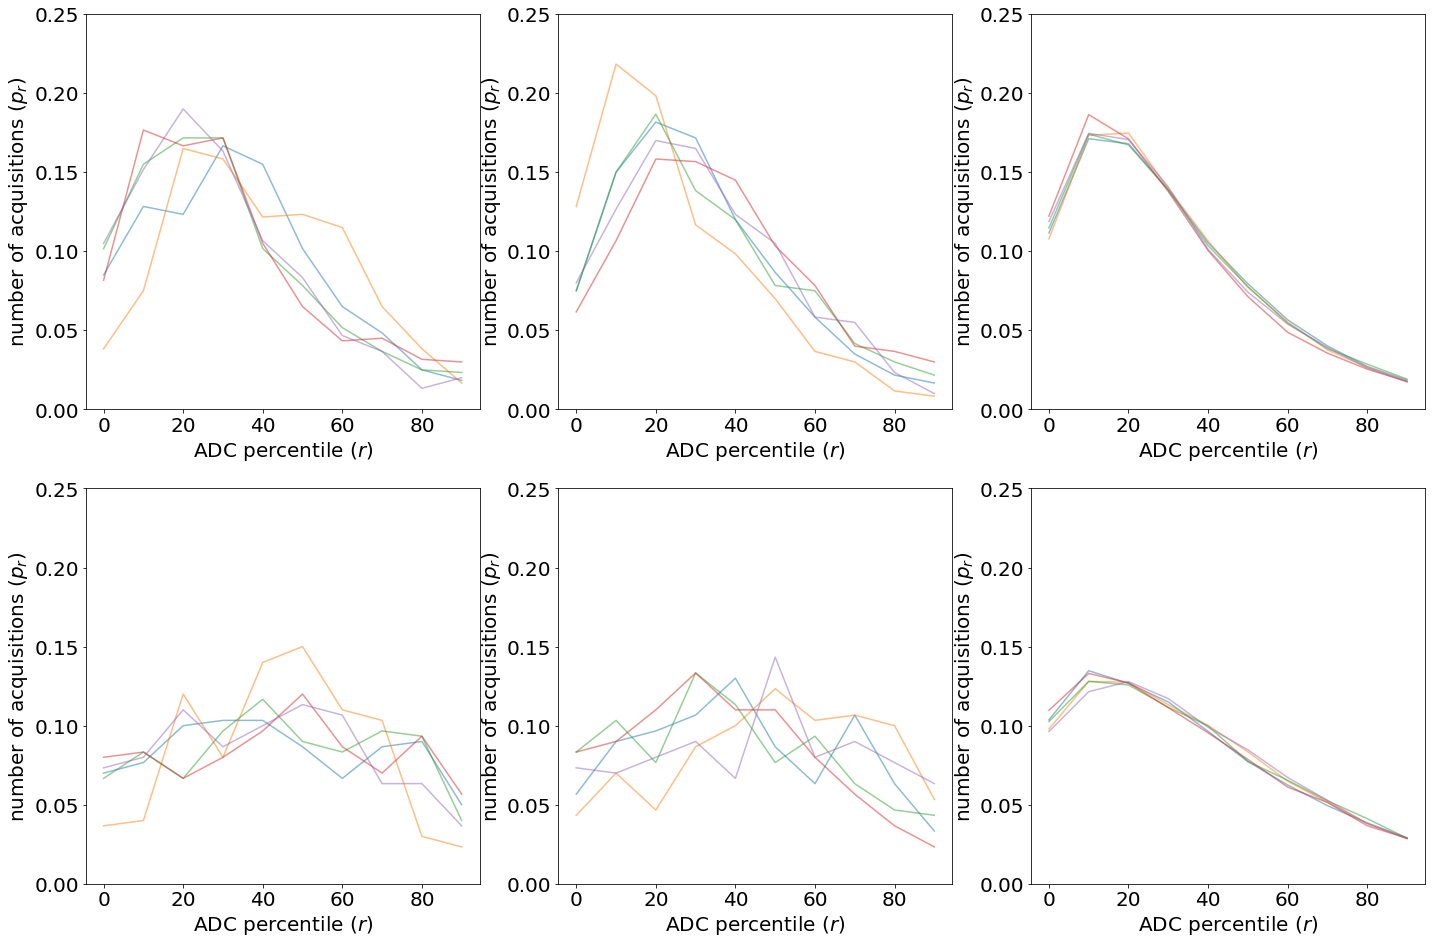

In [33]:
bins = np.linspace(0+eps, 1-eps, 11)
fig, ax = plt.subplots(2,3, figsize=(24, 16))
bins2 = [x*10 for x in range(10)]
for case_no in [0,1,2,3,4,6,7,8,9,10]:#range(len(cases)):
    
    row = 0 if case_no<5 else 1
    divider = 24 if case_no<5 else 12
    _case = cases[case_no]
    adc = calc_adc(_case.b3, _case.b0, _case.b[3],_case.b[0])
    benign_center = _case.contralateral_loc
    noise_center = _case.noise
    center = _case.cancer_loc
    _slice = _case.cancer_slice
    c = np.asarray(adc[benign_center[0] - 2: benign_center[0] + 3, benign_center[1] - 2 : benign_center[1] + 3, _slice, :])
    a = np.zeros(10,)
    ctr = 0
    for i in range(5):
        for j in range(5):
            c1 = c[i,j].flatten()
            c1 = (c1-np.min(c1))/(np.max(c1) - np.min(c1))
            _a, _ = np.histogram(c1, bins)
            if sum(_a):
                a += _a/divider
                ctr +=1
    #ax[row][1].plot(bins[:-1], a/ctr, alpha=0.5)
    ax[row][1].plot(bins2, a/ctr, alpha=0.5)
    ax[row][1].set_ylim(0,0.25)
    ax[row][1].tick_params(axis='x', labelsize=20)
    ax[row][1].tick_params(axis='y', labelsize=20)
    ax[row][1].set_xlabel('ADC percentile ($r$)', fontsize=20)
    ax[row][1].set_ylabel('number of acquisitions ($p_r$)', fontsize=20) 
    a = np.zeros(10,)
    c = np.asarray(adc[center[0] - 2: center[0] + 3, center[1] - 2 : center[1] + 3, _slice, :])
    ctr = 0
    for i in range(5):
        for j in range(5):
            c1 = c[i,j].flatten()
            c1 = (c1-np.min(c1))/(np.max(c1) - np.min(c1))
            _a, _ = np.histogram(c1, bins)
            if sum(_a):
                a += _a/divider
                ctr +=1
    #ax[row][0].plot(bins[:-1], a/ctr, alpha=0.5)
    ax[row][0].plot(bins2, a/ctr, alpha=0.5)
    ax[row][0].set_ylim(0,0.25)
    ax[row][0].tick_params(axis='x', labelsize=20)
    ax[row][0].tick_params(axis='y', labelsize=20)
    ax[row][0].set_xlabel('ADC percentile ($r$)', fontsize=20)
    ax[row][0].set_ylabel('number of acquisitions ($p_r$)', fontsize=20) 
    a = np.zeros(10,)
    ctr = 0
    for i in range(40,90):
        for j in range(40,90):
            c1 = adc[i, j, _slice, :]
            #c1 = c[i,j].flatten()
            c1 = (c1-np.min(c1))/(np.max(c1) - np.min(c1))
            _a, _ = np.histogram(c1, bins)
            if sum(_a):
                a += _a/divider
                ctr +=1
    ax[row][2].plot(bins2, a/ctr, alpha=0.5)
    ax[row][2].set_ylim(0,0.25)
    ax[row][2].tick_params(axis='x', labelsize=20)
    ax[row][2].tick_params(axis='y', labelsize=20)
    ax[row][2].set_xlabel('ADC percentile ($r$)', fontsize=20)
    ax[row][2].set_ylabel('number of acquisitions ($p_r$)', fontsize=20)  
    #print(np.cumsum(a/ctr))

In [ ]:

ROI_cancer_nerc = np.zeros((3, 3, 24))
ROI_benign_nerc = np.zeros((3, 3, 24))
acq = []
pt = 2
case_numbers = [0,1,2,3,4]
case_numbers.pop(pt)
print(case_numbers)
b0_th = 10
b3_th = 0
for case_no in case_numbers:
    print(case_no)
    _case = cases[case_no]
    signal = _case.b3
    b0 = _case.b0
    _slice = _case.cancer_slice
    noise_b0 = np.std(_case.b0[noise_center[0]-1:noise_center[0]+1, noise_center[1]-1:noise_center[1]+1, _slice])
    mask = b0 > b0_th
    mask2 = signal > b3_th
    data_segmented = mask2*signal
    b0_segmented = mask*b0
    adc = calc_adc(data_segmented[35:95,35:95,:,:], b0_segmented[35:95,35:95,:], _case.b[3], _case.b[0])
    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(np.mean(adc[:,:,_slice],-1))
    acq.append(adc.flatten())
x = np.hstack(acq)
x = x.flatten()
x = x[~np.isnan(x)]
x = x[~np.isinf(x)]
bins = np.linspace(0, 6,150)
fig, ax = plt.subplots(1, figsize=(6,6))
ax.hist(x, bins, alpha=0.5)
gm = GaussianMixture(n_components=2, random_state=0).fit(x.reshape(-1, 1))

for i in range(2):
    print(gm.means_[i], gm.covariances_[i])
    print(gm.means_[i] - 2*gm.covariances_[i])



_case = cases[pt]
signal = _case.b3
b0 = _case.b0
mask = b0 > b0_th
mask2 = signal > b3_th
data_segmented = mask2*signal
b0_segmented = mask*b0
adc = calc_adc(signal, b0, _case.b[3], _case.b[0])
benign_center = _case.contralateral_loc
_slice = _case.cancer_slice
center = _case.cancer_loc
ROI_cancer_nerc = np.asarray(adc[center[0] - 1: center[0] + 2,
                                                             center[1] - 1 : center[1] + 2, _slice, :])
ROI_benign_nerc = np.asarray(adc[benign_center[0] - 1: benign_center[0] + 2, 
                                                               benign_center[1] - 1 : benign_center[1] + 2, _slice, :])




In [ ]:
ERD_th = 5
for i in range(2):
    if (gm.means_[i] - 1*gm.covariances_[i]) < ERD_th:
        ERD_th = gm.means_[i] - 1*gm.covariances_[i]

print(ERD_th)

In [23]:
def calc_adc_erd_single3(_case, _slice):
    c = 1.1 if _case.b[3]==1500 else 1.4
    eps = 1e-7
    def onehot(x):
        _max = np.argmax(x)
        a = np.zeros_like(x)
        a[_max] = 1
        return a
    def calc_mean_adc(Sb, S0, bval):
        adc = np.zeros((S0.shape))        
        adc = -np.log(Sb/(S0 + eps) + eps)/(bval)
        return adc*1000
    mean_image = np.zeros((_case.b0.shape[0], _case.b0.shape[1]))
    noise_center = _case.noise
    noise_level = np.std(_case.b3[noise_center[0]-3:noise_center[0]+2, 
                                  noise_center[1]-3:noise_center[1]+2,
                                  _slice])/np.sqrt(2-np.pi/2)
    for i in range(_case.b0.shape[0]):
        for j in range(_case.b0.shape[1]):
            x = _case.b3[i, j, _slice, :]
            b_zero = _case.b0[i,j,_slice]
            adc = -1000*np.log(np.mean(x)/b_zero)/_case.b[3]
            if np.mean(x)>2*noise_level:
                #temp = max(mul*np.exp(slope*(adc-2)), 0.5)
                temp = 25*np.tanh(10*(adc-c))+25.5
                try:
                    x = x.astype(np.float64)
                    a = np.exp(x/temp)/np.sum(np.exp(x/temp))
                except RuntimeWarning:
                    a = onehot(x)
                    print('here')
                    
                y = np.sum(a*x)
                mean_image[i,j] = y
            else:
                mean_image[i,j] = np.mean(x)

    return calc_mean_adc(mean_image, _case.b0[:,:, _slice], _case.b[3])

17-1694-102


<ipython-input-3-77b50080dad9>:12: RuntimeWarning: divide by zero encountered in true_divide
  adc[:, :, :, acq] = -np.log((high_b_img[:, :, :, acq1]/low_b_img[:, :, :, acq2]))/(bval_high-bval_low)
<ipython-input-3-77b50080dad9>:12: RuntimeWarning: invalid value encountered in true_divide
  adc[:, :, :, acq] = -np.log((high_b_img[:, :, :, acq1]/low_b_img[:, :, :, acq2]))/(bval_high-bval_low)
<ipython-input-3-77b50080dad9>:12: RuntimeWarning: divide by zero encountered in log
  adc[:, :, :, acq] = -np.log((high_b_img[:, :, :, acq1]/low_b_img[:, :, :, acq2]))/(bval_high-bval_low)
<ipython-input-25-ed1266293bc1>:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3, figsize=(18,6))


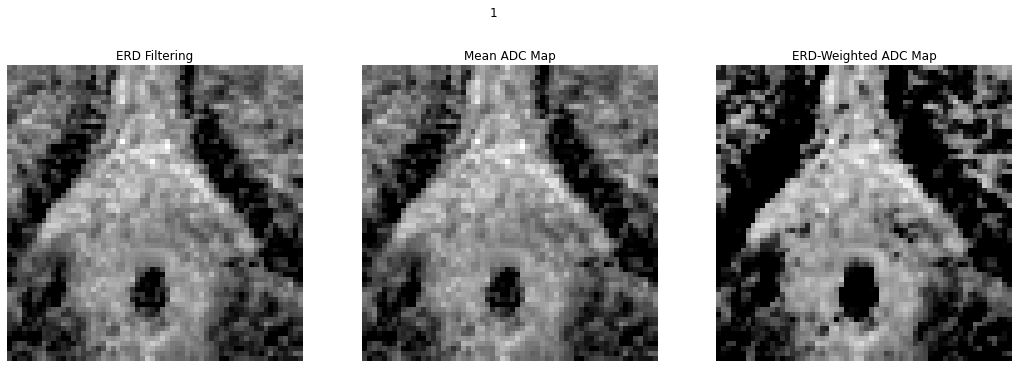

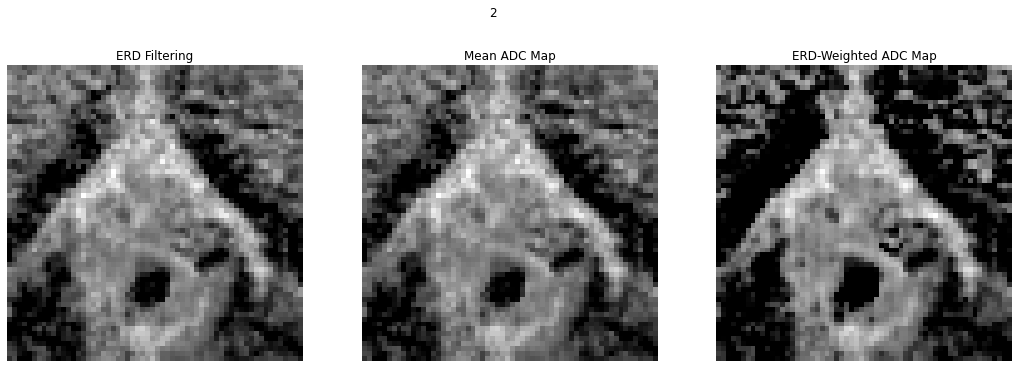

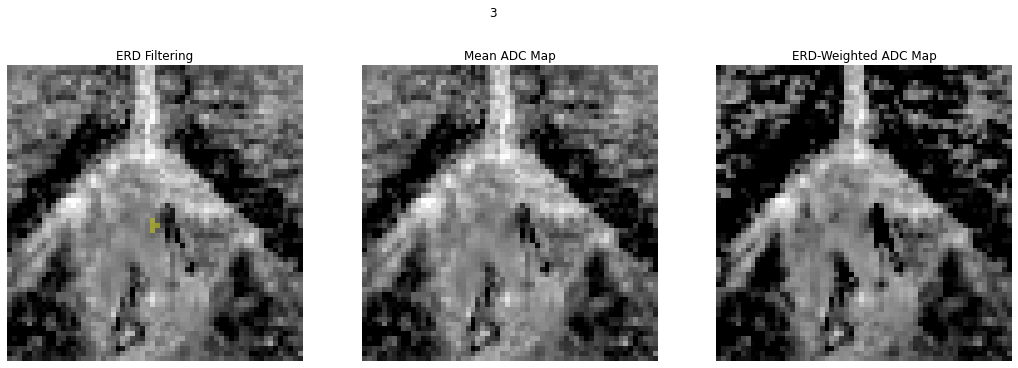

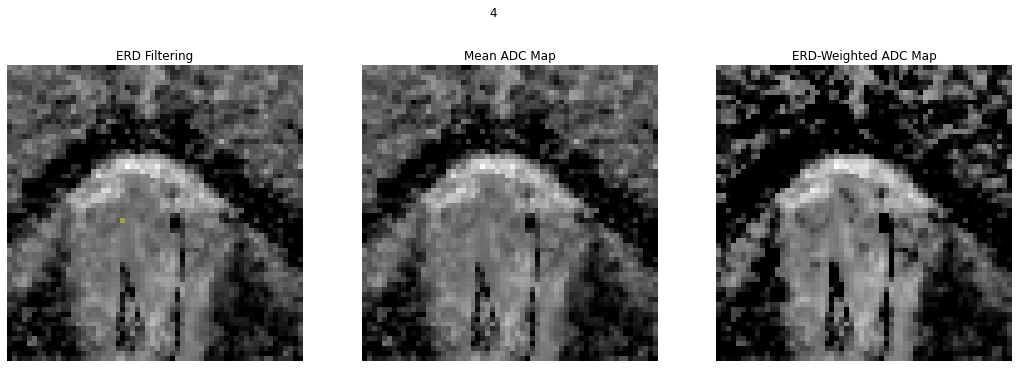

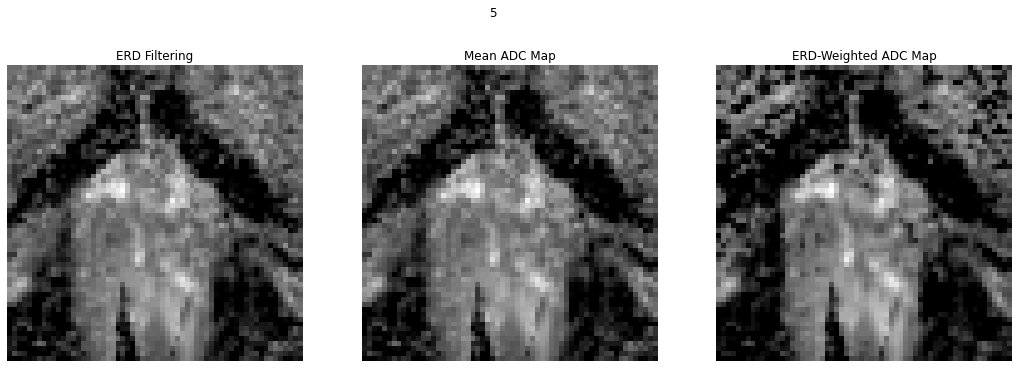

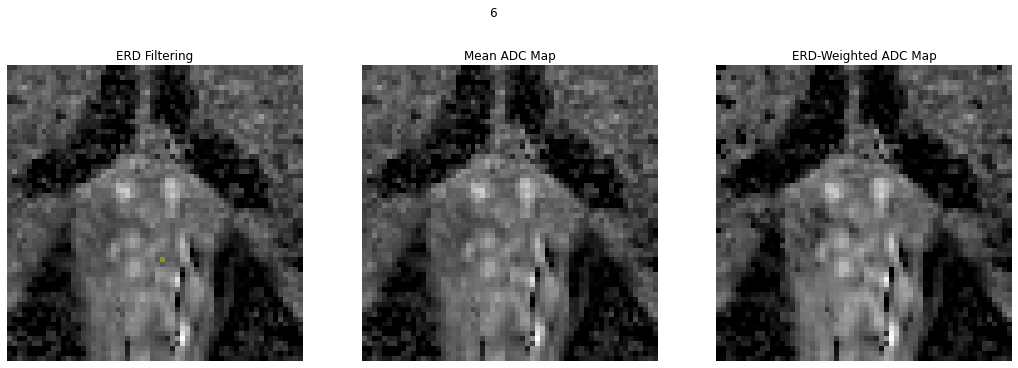

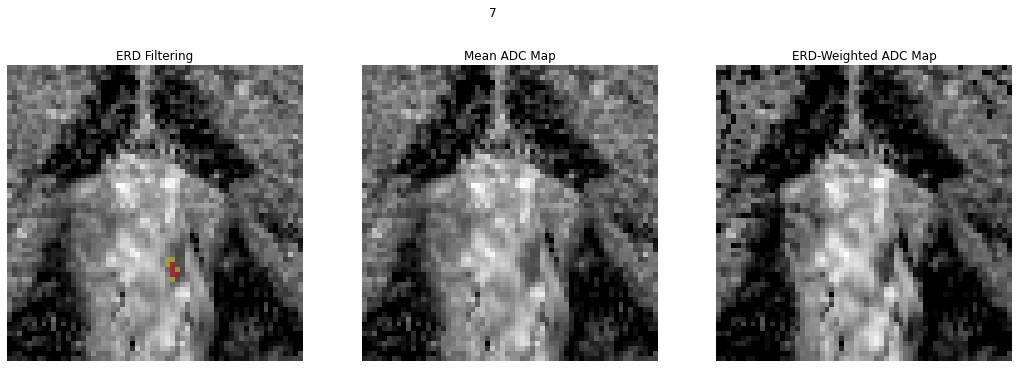

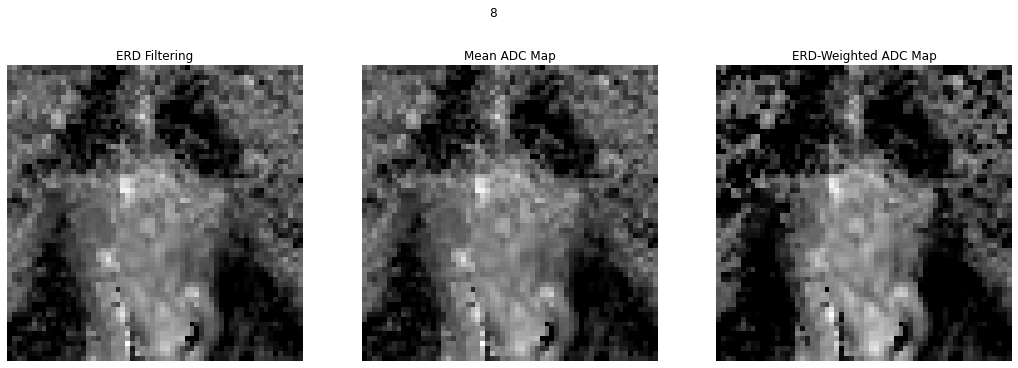

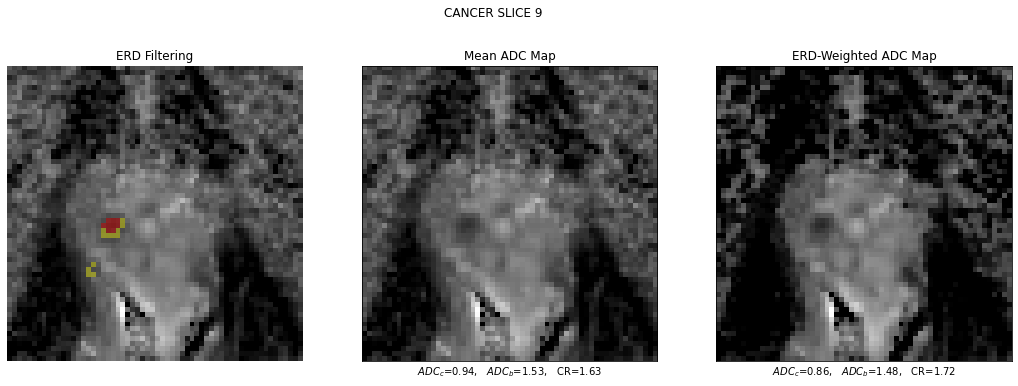

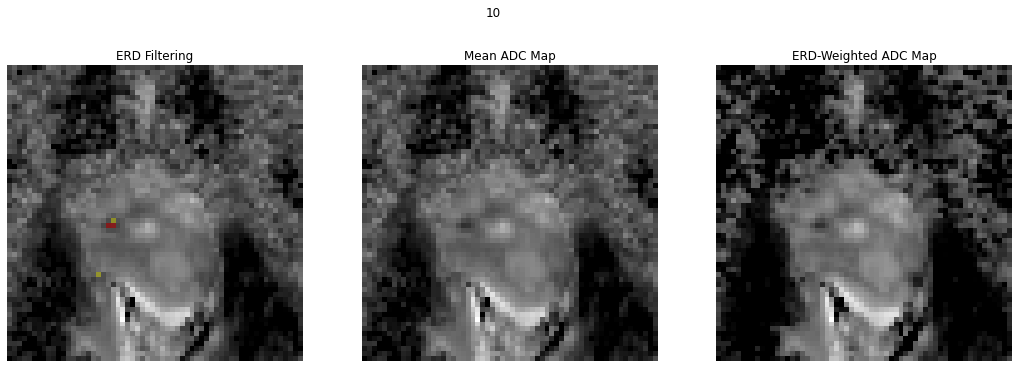

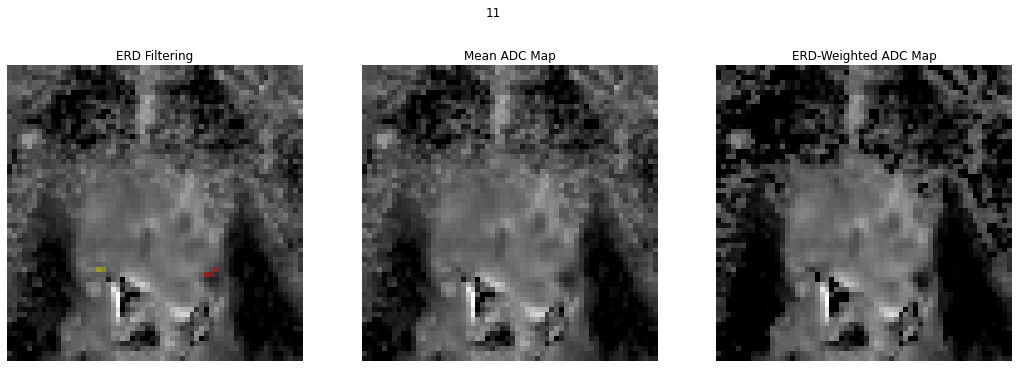

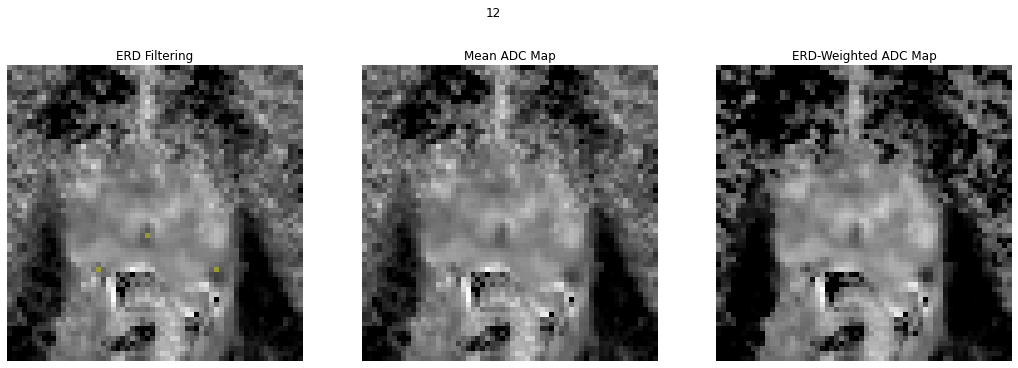

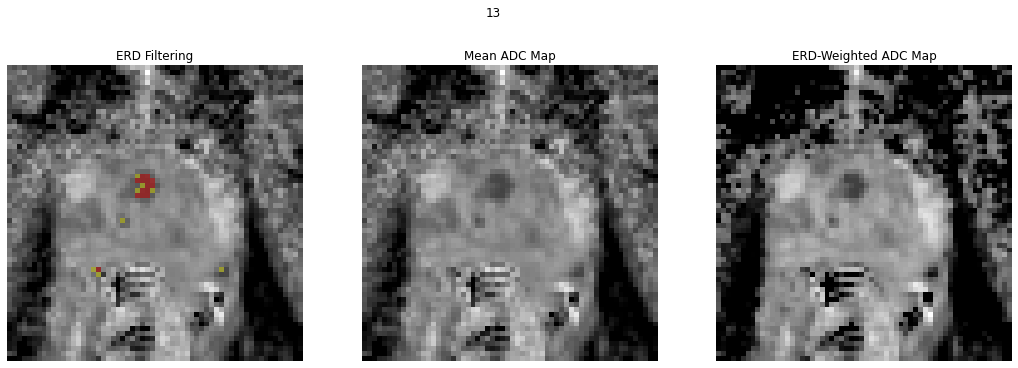

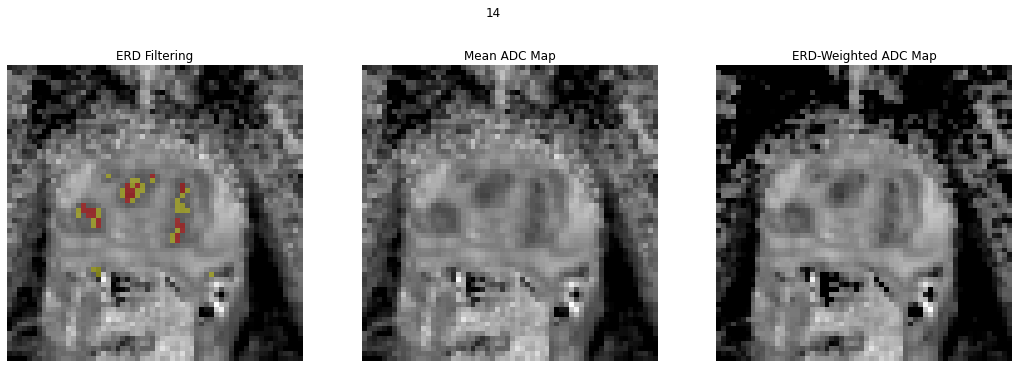

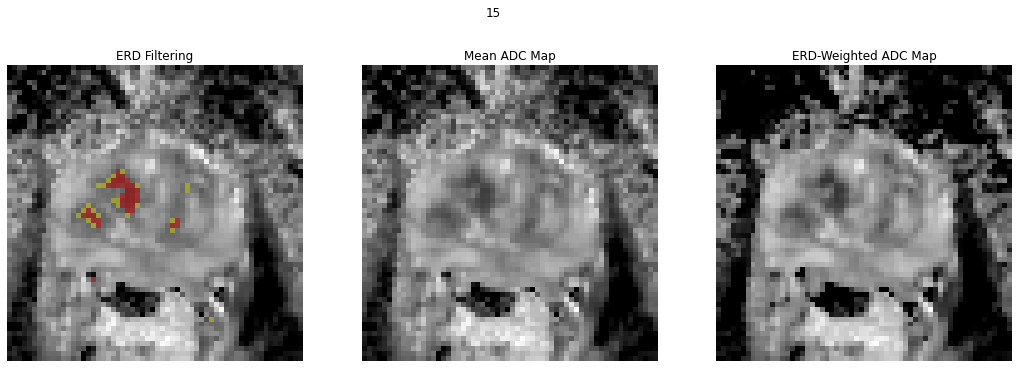

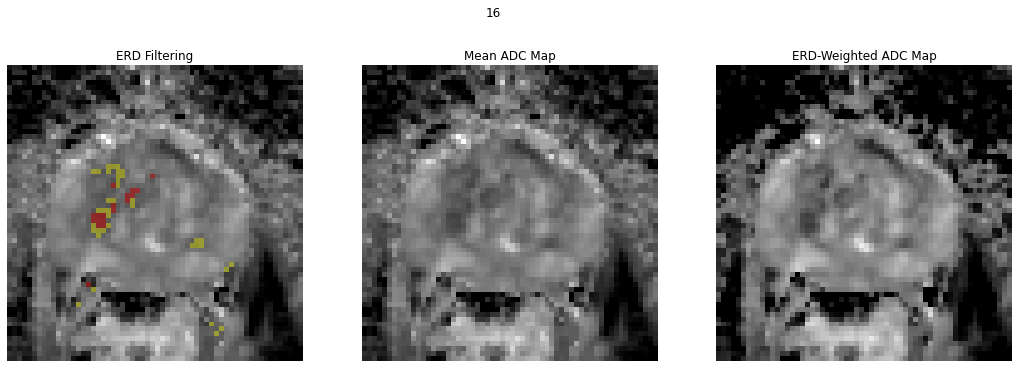

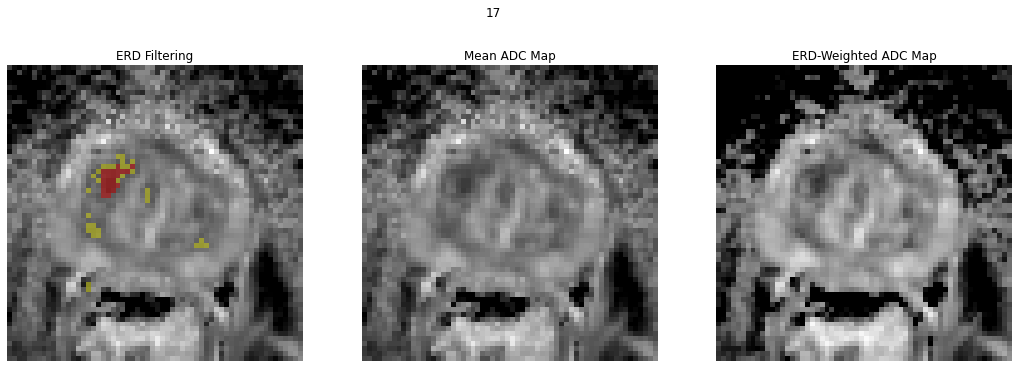

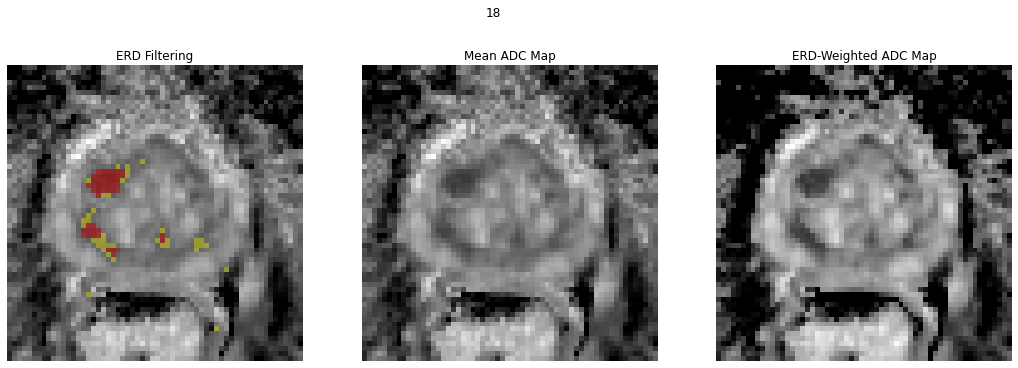

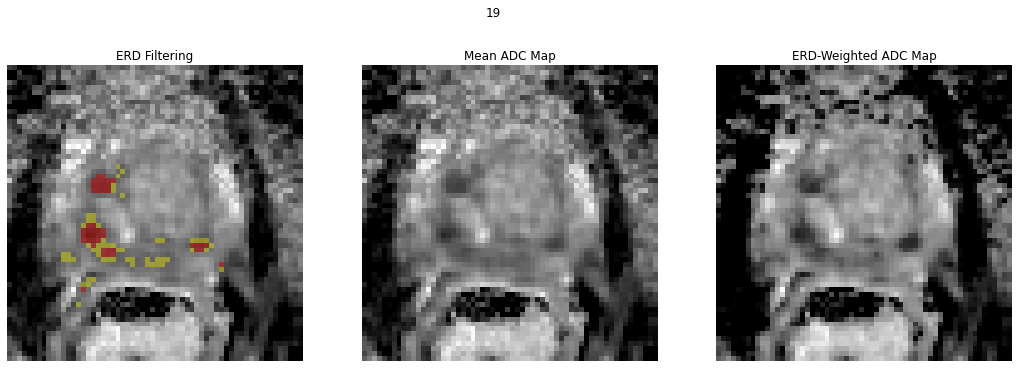

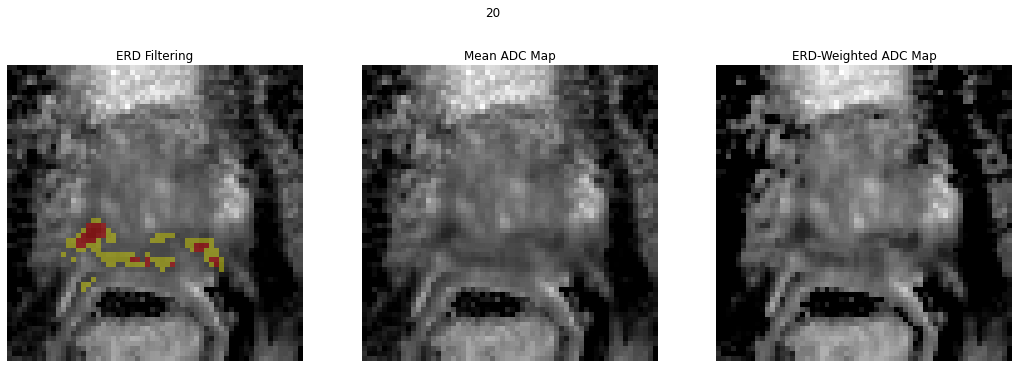

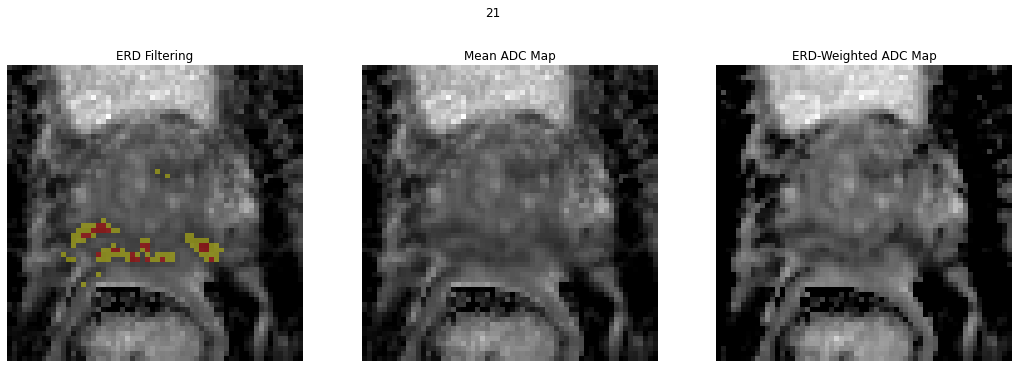

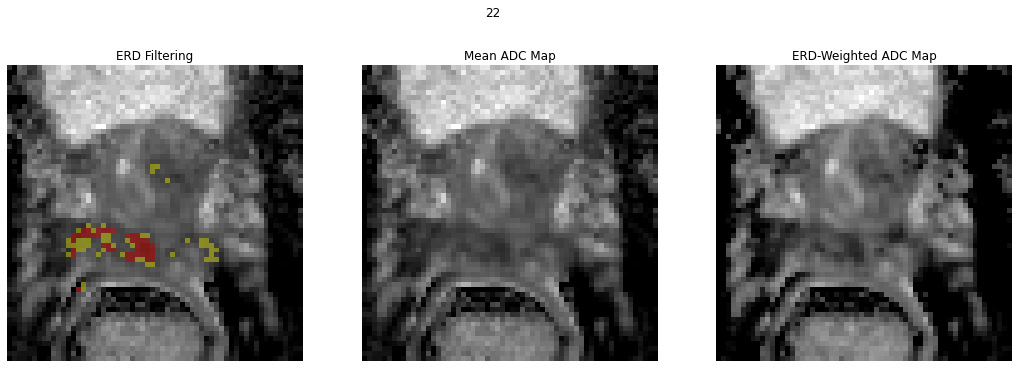

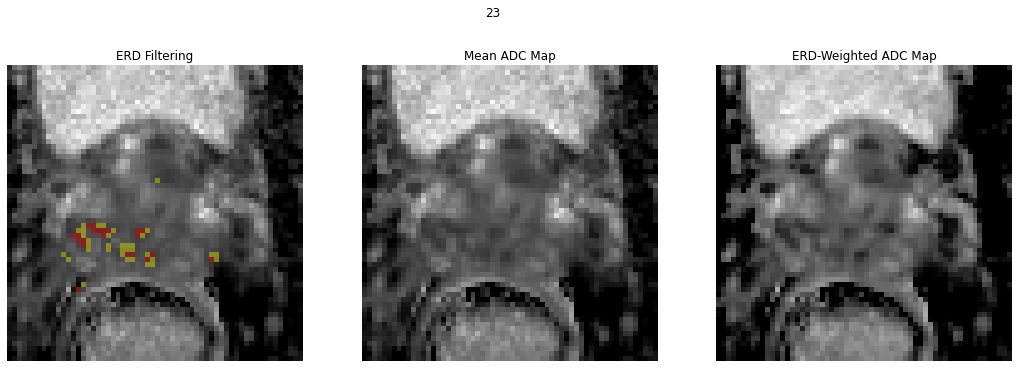

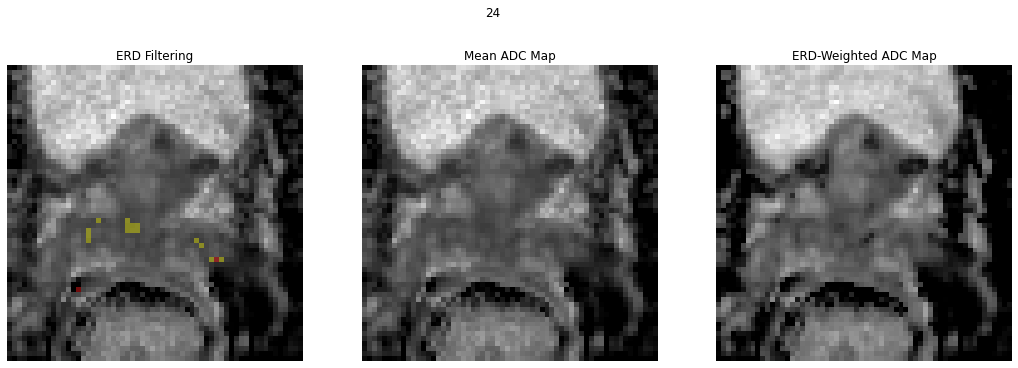

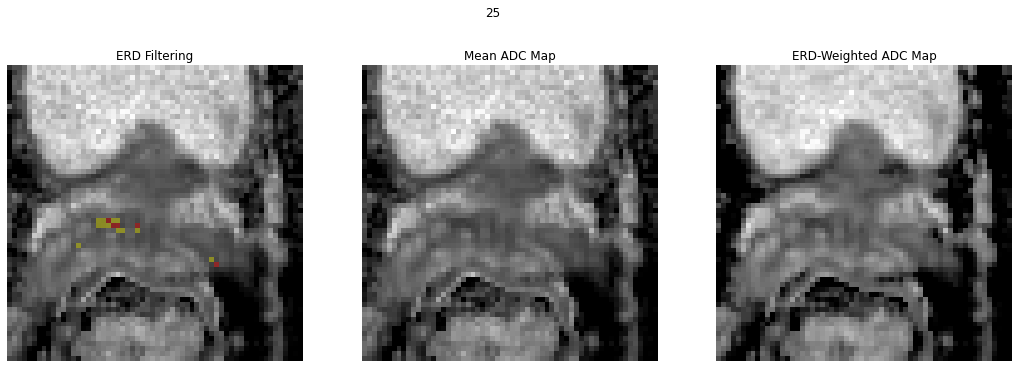

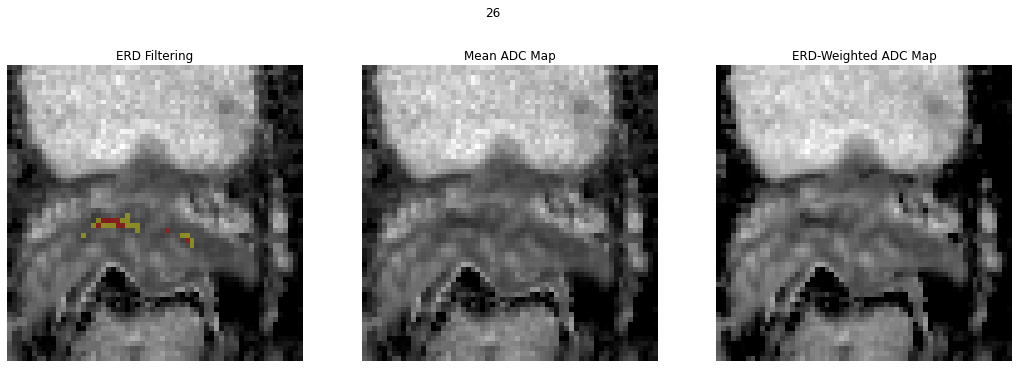

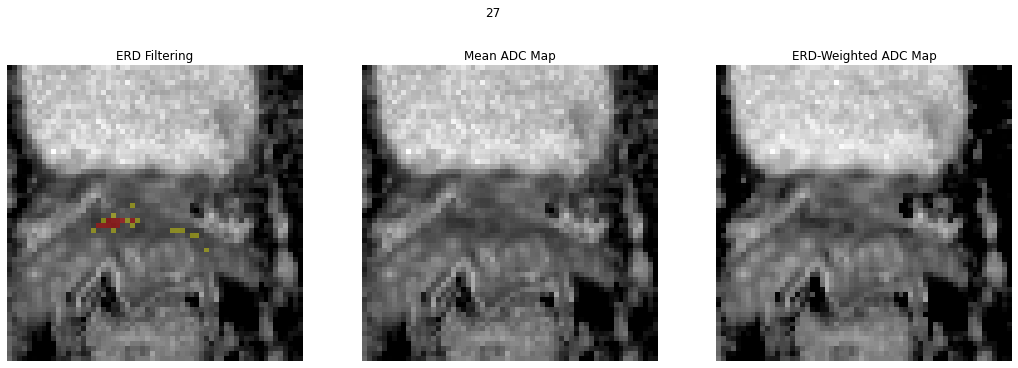

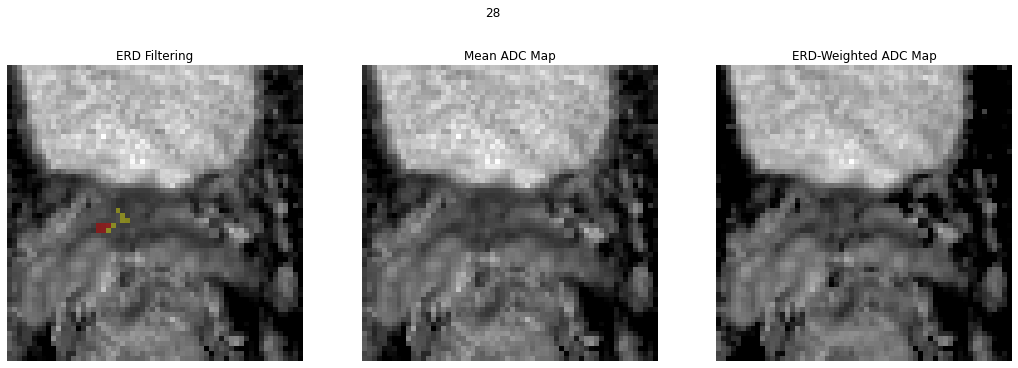

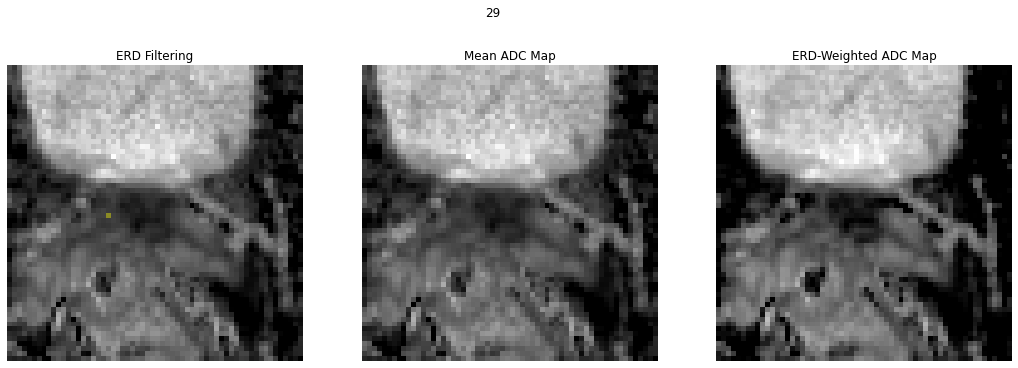

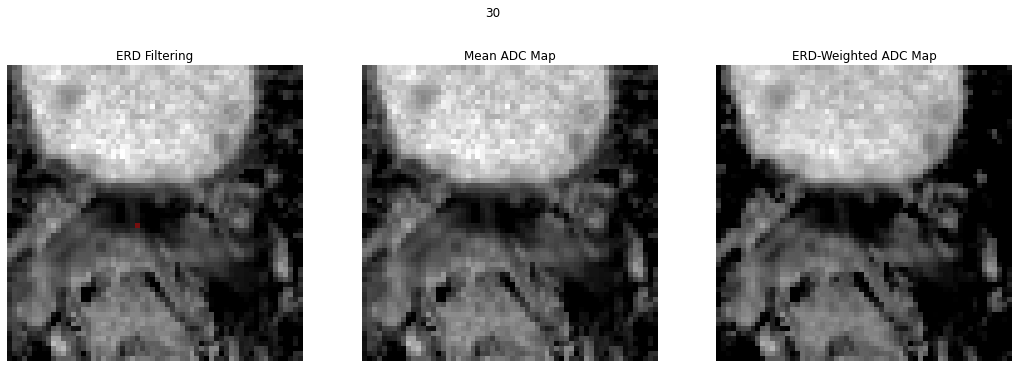

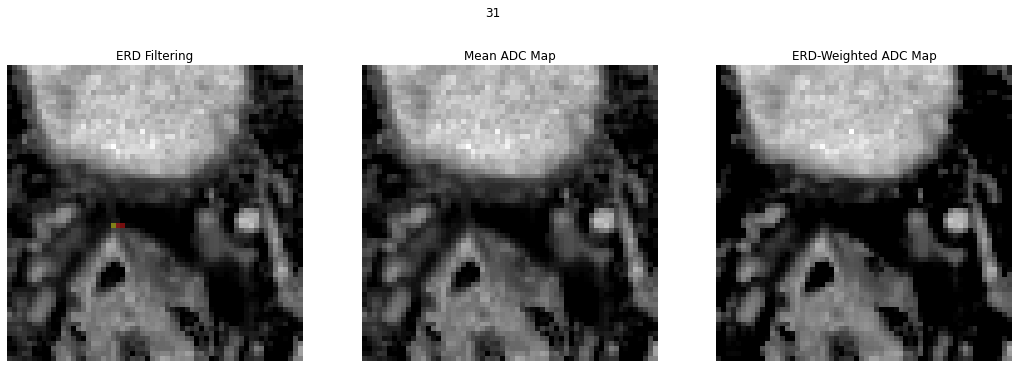

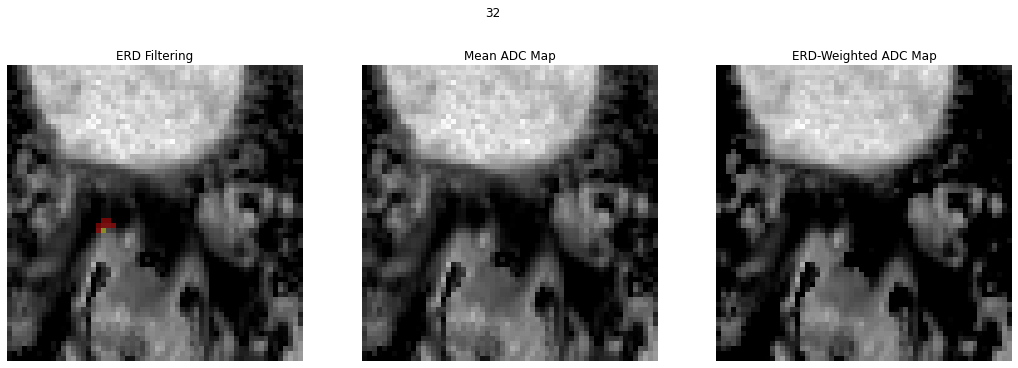

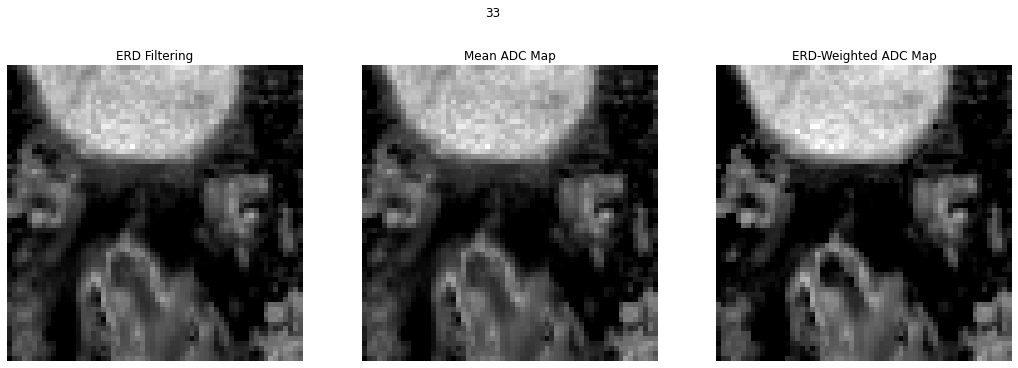

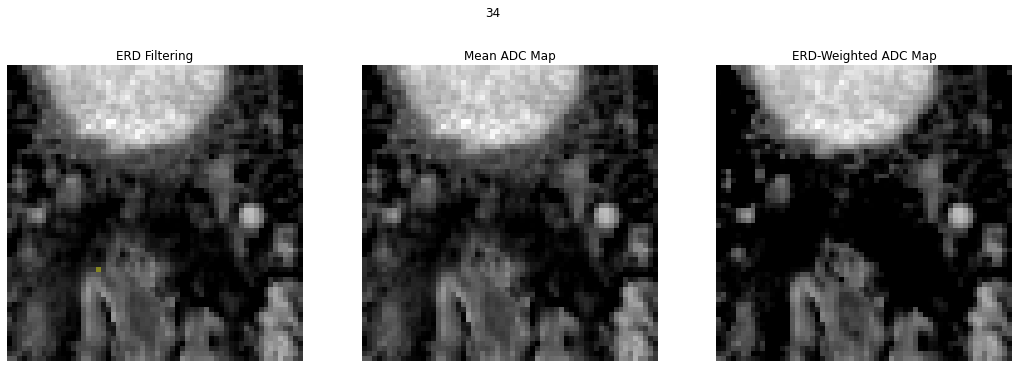

In [25]:
from matplotlib import colors as cls
pt = 12
b0_th = 20
b3_th = 1
b0_th = 45
b3_th = 20
ROI_cancer = 1000*np.ones((3, 3, 24))
ROI_benign = 1000*np.ones((3, 3, 24))
_case = cases[pt]
signal = _case.b3
b0 = _case.b0
adc = calc_adc(signal, b0, _case.b[3], _case.b[0])
#adc2 = calc_mean_adc(signal, b0, _case.b[3], _case.b[0])
benign_center = _case.contralateral_loc
_slice = _case.cancer_slice
center = _case.cancer_loc
ROI_cancer[:,:,:adc.shape[3]] = np.asarray(adc[center[0] - 1: center[0] + 2,
                                                             center[1] - 1 : center[1] + 2, _slice, :])
ROI_benign[:,:,:adc.shape[3]] = np.asarray(adc[benign_center[0] - 1: benign_center[0] + 2, 
                                                               benign_center[1] - 1 : benign_center[1] + 2, _slice, :])
ERD_th=1.04
ROI_start = 35
# counts_cancer = ROI_cancer < ERD_th
# counts_benign = ROI_benign < ERD_th
# print("overall rejection within cancer ROI")
# print(1-np.sum(np.sum(np.sum(counts_cancer,2),1))/(12*9))
# print("x -direction")
# print(1-np.sum(np.sum(np.sum(counts_cancer[:,:,:4],2),1)/(4*9)))
# print("y -direction")
# print(1-np.sum(np.sum(np.sum(counts_cancer[:,:,4:8],2),1)/(4*9)))
# print("z -direction")
# print(1-np.sum(np.sum(np.sum(counts_cancer[:,:,8:12],2),1)/(4*9)))
# pt_cancer = np.sum(counts_cancer[:, : ,:12], 2)
# pt_cancer_bin = pt_cancer >= 1
# pt_benign = np.sum(counts_benign[:, : ,:12], 2)
# pt_benign_bin = pt_benign >= 12
# print('------------------------------------------------------')
# print(f'patient = {pt+1}')
# print(f'avg cancer acquisitions below th = {pt_cancer.mean()}')
# print(f'avg benign acquisitions below th = {pt_benign.sum()/(9*12)}')
# print(f'# frequently detected cancer voxels = {pt_cancer_bin.sum()/9}')
# print(f'# frequently detected benign acq = {pt_benign_bin.sum()/(9*12)}')
# print(f'# frequently detected benign voxels = {pt_benign_bin.sum()/9}')
signal = _case.b3
b0 = _case.b0
print(_case.pt_id)
mask = b0 > b0_th
mask2 = signal >b3_th
data_segmented = mask2*signal
b0_segmented = mask*b0
center = _case.cancer_loc
benign_center = _case.contralateral_loc
_slice = _case.cancer_slice
for _slice in range(34):#(_case.cancer_slice,_case.cancer_slice+1,_case.cancer_slice-1, _case.cancer_slice-6):
    adc = calc_adc(data_segmented[35:95, 35:95, :, :], b0_segmented[35:95, 35:95, :], _case.b[3], _case.b[0])
    pt_erd = adc<ERD_th
    #print(pt_erd.sum()/(50*50*24*28))
    fig, ax = plt.subplots(1,3, figsize=(18,6))
    img = np.mean(adc[:, :, _slice, :], -1)
    erd = np.mean(pt_erd[:, :, _slice, :], 2) * (~np.isnan(img))
    x_start = center[1] - 0.5 - ROI_start
    y_start = center[0] - 0.5 - ROI_start
    rect = patches.Rectangle((x_start-1, y_start-1), 3, 3, edgecolor='green', lw=5, facecolor='none', alpha=0.9)
    #ax.add_patch(rect)
    adc = calc_adc(signal[35:95, 35:95, :, :], b0[35:95, 35:95, :], _case.b[3], _case.b[0])
    img = np.mean(adc[:, :, _slice, :], 2)
    erd [erd < 0.5] = 0 ## <------ Here's where we question the coherence of acquisitions
    erd[erd==0] = np.nan
    erd [erd < 0.8 ] = 0.1
    erd [erd >= 0.8] = 0.2
    cmap = cls.ListedColormap(['yellow', 'red'])
    soft = calc_adc_erd_single3(_case, _slice)
    ax[0].imshow(img, cmap='gray', vmin=0.2)
    ax[0].imshow(erd, cmap=cmap,vmin=0.1,vmax=0.2,alpha = 0.4)
    ax[0].set_title(f'ERD Filtering')
    ax[1].imshow(img, cmap='gray', vmin=0.2)
    ax[1].set_title(f'Mean ADC Map')
    ax[2].imshow(soft[35:95, 35:95], cmap='gray', vmin=0.2)
    ax[2].set_title(f'ERD-Weighted ADC Map')
    ax[0].axis('off')
    if _slice != _case.cancer_slice:
        fig.suptitle(str(_slice + 1))
        ax[1].axis('off')   
        ax[2].axis('off')            
    else:
        adc = calc_adc(signal, b0, _case.b[3], _case.b[0])
        fig.suptitle('CANCER SLICE ' + str(_slice + 1))
        adc_c = 'ADC_c'
        adc_b = 'ADC_b'
        cancer_mean = np.mean(adc[center[0]-1:center[0]+2, center[1]-1:center[1]+2, _slice])
        ben_mean = np.mean(adc[benign_center[0]-1:benign_center[0]+2, benign_center[1]-1:benign_center[1]+2, _slice])
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_xlabel(f'${{{adc_c}}}$={cancer_mean:.2f},   ${{{adc_b}}}$={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}')

        cancer_mean = np.mean(soft[center[0]-1:center[0]+2, center[1]-1:center[1]+2])
        ben_mean = np.mean(soft[benign_center[0]-1:benign_center[0]+2, benign_center[1]-1:benign_center[1]+2])

        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[2].set_xlabel(f'${{{adc_c}}}$={cancer_mean:.2f},   ${{{adc_b}}}$={ben_mean:.2f},   CR={(ben_mean/cancer_mean):.2f}')
    
    
    '''
    for i in range(2):
        x_start = measured[i][1] - 0.5 - ROI_start
        y_start = measured[i][0] - 0.5 - ROI_start
        rect = patches.Rectangle((x_start-1, y_start-1), 3, 3, edgecolor='black', facecolor=colors[i], alpha=0.3)
        ax[1].add_patch(rect)

    
    if _slice != _case.cancer_slice:
        ROI_benign = calc_adc(signal*mask2, b0*mask, _case.b[3], _case.b[0])
        ROI_benign = ROI_benign[:,:,_slice]
        num_voxels = sum(((~np.isnan(ROI_benign))*(ROI_benign!=-np.inf)).flatten())
        ROI = sum((np.sum((~np.isnan(ROI_benign))*(ROI_benign!=-np.inf),2)>0).flatten())
        print(num_voxels)
        ROI_benign[np.isnan(ROI_benign)] = 10
        ROI_benign[ROI_benign==-np.inf] = 10   
        pt_erd = ROI_benign < ERD_th
        print(f'voxels = {100*sum((np.sum(pt_erd, 2) > 6).flatten())/ROI}')
        print(f'acq = {100*sum(pt_erd.flatten())/(num_voxels)}')
    '''
    

In [ ]:
erd[erd==0.6]

In [ ]:
ERD_th = 5
for i in range(2):
    if (gm.means_[i] - 2*gm.covariances_[i]) < ERD_th:
        ERD_th = gm.means_[i] - 2*gm.covariances_[i]

for pt in range(5):
    _case = cases[pt]
    signal = _case.dwi
    b0 = _case.b0
    mask = b0 > b0_th
    mask2 = signal > data_th
    data_segmented = mask2*signal
    b0_segmented = mask*b0
    benign_center = _case.contralateral_loc
    center = _case.cancer_loc
    _slice = _case.cancer_slice -6
    adc = calc_adc(data_segmented[40:90, 40:90, :, :], b0_segmented[40:90, 40:90, :], _case.b)
    ROI_benign_nerc = adc[:,:, _slice, :]
    num_voxels = sum(((~np.isnan(ROI_benign_nerc))*(ROI_benign_nerc!=-np.inf)).flatten())
    ROI = sum((np.sum((~np.isnan(ROI_benign_nerc))*(ROI_benign_nerc!=-np.inf),2)>0).flatten())
    #print(num_voxels)
    ROI_benign_nerc[np.isnan(ROI_benign_nerc)] = 10
    ROI_benign_nerc[ROI_benign_nerc==-np.inf] = 10   
    pt_erd = ROI_benign_nerc < ERD_th
    print(f'voxels = {100*sum((np.sum(pt_erd, 2) > 12).flatten())/ROI}')
    print(f'acq = {100*sum(pt_erd.flatten())/(num_voxels)}')
    

In [ ]:
ROI_cancer_erc = np.zeros((5, 3, 3, 12))
ROI_benign_erc = np.zeros((5, 3, 3, 12))
 
b0_th = 40
data_th = 6
acq = []
for case_no in range(5,10):
    print(case_no)
    _case = cases[case_no]
    signal = _case.b3
    b0 = _case.b0
    mask = b0 > b0_th
    mask2 = signal > data_th
    data_segmented = mask2*signal
    b0_segmented = mask*b0
    adc = calc_adc(data_segmented, b0_segmented, _case.b[3], _case.b[0])
    acq.append(adc.flatten())
x = np.hstack(acq)
x = x.flatten()
x = x[~np.isnan(x)]
x = x[~np.isinf(x)]
bins = np.linspace(0, 6, 150)
plt.hist(x, bins, alpha=0.5)
gm = GaussianMixture(n_components=2, random_state=0).fit(x.reshape(-1, 1))
 

for case_no in range(6,11):
    _case = cases[case_no]
    signal = _case.b3
    b0 = _case.b0
    mask = b0 > b0_th
    mask2 = signal > data_th
    adc = calc_adc(signal, b0, _case.b[3], _case.b[0])
    benign_center = _case.contralateral_loc
    _slice = _case.cancer_slice
    center = _case.cancer_loc
    ROI_cancer_erc[case_no-6, :, :, :] = np.asarray(adc[center[0] - 1: center[0] + 2,
                                                        center[1] - 1 : center[1] + 2, _slice, :])
    ROI_benign_erc[case_no-6, :, :, :] = np.asarray(adc[benign_center[0] - 1: benign_center[0] + 2,
                                                        benign_center[1] - 1 : benign_center[1] + 2, _slice, :])

In [ ]:
print(gm.means_)
print(gm.covariances_)

In [19]:
ERD_th = 5
# for i in range(2):
#     if (gm.means_[i] - 2*gm.covariances_[i]) < ERD_th:
#         ERD_th = gm.means_[i] - 2*gm.covariances_[i]

print(ERD_th)
ERD_th = 1.04
counts_cancer = ROI_cancer_erc < ERD_th
counts_benign = ROI_benign_erc < ERD_th
#overall rejection
print(1-np.mean(np.sum(np.sum(np.sum(counts_cancer,3),2),1)/(12*9)))
#x
print(np.sum(np.sum(np.sum(counts_cancer[:,:,:,:4],3),2),1)/(4*9))
print(1-np.mean(np.sum(np.sum(np.sum(counts_cancer[:,:,:,:4],3),2),1)/(4*9)))
#y
print(np.sum(np.sum(np.sum(counts_cancer[:,:,:,4:8],3),2),1)/(4*9))
print(1-np.mean(np.sum(np.sum(np.sum(counts_cancer[:,:,:,4:8],3),2),1)/(4*9)))
#z
print(np.sum(np.sum(np.sum(counts_cancer[:,:,:,8:],3),2),1)/(4*9))
print(1-np.mean(np.sum(np.sum(np.sum(counts_cancer[:,:,:,8:],3),2),1)/(4*9)))

b0_th = 40
data_th = 20
for pt in range(6,12):
    pt_cancer = np.sum(counts_cancer[pt-6, :, : ,:], 2)
    pt_cancer_bin = pt_cancer >= 1
    pt_benign = np.sum(counts_benign[pt-6, :, : ,:], 2)
    pt_benign_bin = pt_benign > 6
    print('------------------------------------------------------')
    print(f'patient = {pt+1}')
    print(f'avg cancer acquisitions below th = {pt_cancer.mean()}')
    print(f'avg benign acquisitions below th = {pt_benign.mean().mean()}')
    print(f'# frequently detected cancer voxels = {pt_cancer_bin.sum()/9}')
    print(f'# frequently detected benign acq = {pt_benign.sum()/(9*12)}')
    print(f'# frequently detected benign voxels = {pt_benign_bin.sum()/9}')
    _case = cases[pt]
    signal = _case.b3
    b0 = _case.b0
    mask = b0 > b0_th
    mask2 = signal > data_th
    data_segmented = mask2*signal
    b0_segmented = mask*b0
    benign_center = _case.contralateral_loc
    for _slice in range(b0.shape[2]):
        center = _case.cancer_loc
        adc = calc_adc(data_segmented[40:90, 40:90, :, :], b0_segmented[40:90, 40:90, :], _case.b[3], _case.b[0])
        pt_erd = adc<ERD_th
        fig, ax = plt.subplots(1, figsize=(6,6))
        fig.suptitle(_case.pt_id)
        img = np.mean(adc[:, :, _slice, :], 2)
        erd = np.mean(pt_erd[:, :, _slice, :], 2) * (~np.isnan(img))
        erd[erd==0] = np.nan
        x_start = center[1] - 0.5 - ROI_start
        y_start = center[0] - 0.5 - ROI_start
        rect = patches.Rectangle((x_start-1, y_start-1), 3, 3, edgecolor='green', lw=3, facecolor='none', alpha=0.9)
        #ax.add_patch(rect)
        adc = calc_adc(signal[40:90, 40:90, :, :], b0[40:90, 40:90, :], _case.b[3], _case.b[0])
        img = np.mean(adc[:, :, _slice, :], 2)
        erd [erd < (6/12)] = 0 ## <------ Here's where we question the consistency of acquisitions
        erd[erd==0] = np.nan
        ax.imshow(img, cmap='gray', vmin=0.4)
        ax.imshow(erd, cmap='autumn',alpha = 0.4)
        ax.axis('off')

5


NameError: name 'ROI_cancer_erc' is not defined

In [ ]:
ERD_th = 1.04
b0_th = 40
data_th = 20
pt = 11
_case = cases[pt]
signal = _case.b3
b0 = _case.b0
mask = b0 > b0_th
mask2 = signal > data_th
data_segmented = mask2*signal
b0_segmented = mask*b0
benign_center = _case.contralateral_loc
for _slice in range(b0.shape[2]):
    center = _case.cancer_loc
    adc = calc_adc(data_segmented[40:90, 40:90, :, :], b0_segmented[40:90, 40:90, :], _case.b[3], _case.b[0])
    pt_erd = adc<ERD_th
    fig, ax = plt.subplots(1, figsize=(6,6))
    fig.suptitle(_case.pt_id)
    img = np.mean(adc[:, :, _slice, :], 2)
    erd = np.mean(pt_erd[:, :, _slice, :], 2) * (~np.isnan(img))
    erd[erd==0] = np.nan
    x_start = center[1] - 0.5 - ROI_start
    y_start = center[0] - 0.5 - ROI_start
    rect = patches.Rectangle((x_start-1, y_start-1), 3, 3, edgecolor='green', lw=3, facecolor='none', alpha=0.9)
    #ax.add_patch(rect)
    adc = calc_adc(signal[40:90, 40:90, :, :], b0[40:90, 40:90, :], _case.b[3], _case.b[0])
    img = np.mean(adc[:, :, _slice, :], 2)
    erd [erd < (6/12)] = 0 ## <------ Here's where we question the consistency of acquisitions
    erd[erd==0] = np.nan
    ax.imshow(img, cmap='gray', vmin=0.4)
    ax.imshow(erd, cmap='autumn',alpha = 0.4)
    ax.axis('off')

In [ ]:
ROI_benign_erc

In [ ]:
from scipy import stats

for i in range(10):
    _case = cases[i]
    print(_case.pt_id)
#     x = _case.b3[_case.noise[0]-1:_case.noise[0]+2,
#                  _case.noise[1]-1:_case.noise[1]+2,_slice,:].flatten()
#     k2, p = stats.normaltest(x)
#     print(f'noise p={p}')
#     x = _case.b3[_case.contralateral_loc[0]-1:_case.contralateral_loc[0]+2,
#                  _case.contralateral_loc[1]-1:_case.contralateral_loc[1]+2,_slice,:].flatten()
#     k2, p = stats.normaltest(x)
#     print(f'benign p={p}')
    x = _case.b3[_case.cancer_loc[0]-1:_case.cancer_loc[0]+2,
                 _case.cancer_loc[1]-1:_case.cancer_loc[1]+2,_slice,:].flatten()
    k2, p = stats.normaltest(x)
    print(f'cancer p={p}')

In [14]:
ERD_th = 5
for i in range(2):
    if (gm.means_[i] - 2*gm.covariances_[i]) < ERD_th:
        ERD_th = gm.means_[i] - 2*gm.covariances_[i]

for pt in range(5, 12):
    _case = cases[pt]
    signal = _case.dwi
    b0 = _case.b0
    mask = b0 > b0_th
    mask2 = signal > data_th
    data_segmented = mask2*signal
    b0_segmented = mask*b0
    benign_center = _case.contralateral_loc
    center = _case.cancer_loc
    _slice = _case.cancer_slice -6
    adc = calc_adc(data_segmented[40:90, 40:90, :, :], b0_segmented[40:90, 40:90, :], _case.b)
    ROI_benign_erc = adc[:,:, _slice, :]
    num_voxels = sum(((~np.isnan(ROI_benign_erc))*(ROI_benign_erc!=-np.inf)).flatten())
    ROI = sum((np.sum((~np.isnan(ROI_benign_erc))*(ROI_benign_erc!=-np.inf),2)>0).flatten())
    #print(num_voxels)
    ROI_benign_nerc[np.isnan(ROI_benign_nerc)] = 10
    ROI_benign_nerc[ROI_benign_nerc==-np.inf] = 10   
    pt_erd = ROI_benign_nerc < ERD_th
    print(f'voxels = {100*sum((np.sum(pt_erd, 2) > 6).flatten())/ROI}')
    print(f'acq = {100*sum(pt_erd.flatten())/(num_voxels)}')

NameError: name 'gm' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(0.5, 12))
fig.subplots_adjust(bottom=0.5)
cmap = mpl.cm.autumn
norm = mpl.colors.Normalize(vmin=0, vmax=2)

cb1 = mpl.colorbar.ColorbarBase(ax,
                                cmap = cmap,
                                norm=norm,
                                orientation='vertical')
ax.tick_params(labelsize=22)
fig.show()

In [ ]:
from scipy import stats
rng = np.random.default_rng()
pts = 1000
a = rng.normal(0, 1, size=pts)
b = rng.normal(2, 1, size=pts)
x = np.concatenate((a, b))
k2, p = stats.normaltest(a)
alpha = 1e-3
print("p = {:g}".format(p))

In [ ]:
_case.b1.shape

In [ ]:
eps = 1e-7
def max_min(inpt):
    return np.max(inpt) - np.min(inpt)
def lms_adc(inpt):
    sum_xi_yi = sum([x[0]*x[1] for x in inpt])
    sum_yj = sum([x[1] for x in inpt])
    sum_xi_sum_yj = sum([x[0]*sum_yj for x in inpt])
    sum_x2 = sum([x[0]**2 for x in inpt])
    sum_x = sum([x[0] for x in inpt])
    adc = -(len(inpt)*sum_xi_yi - sum_xi_sum_yj)/(len(inpt)*sum_x2 - sum_x**2 )*1000
    return adc
#for nerc
case_no =1
_case = cases[case_no]
#for x
for i in range(_case.contralateral_loc[0]-2, _case.contralateral_loc[0]+3):
    for j in range(_case.contralateral_loc[1]-2, _case.contralateral_loc[1]+3):

        b0 = [[_case.b[0], np.log(_case.b0[i, j, _slice] + eps)]]
        b1 = [[_case.b[1], np.log(_case.b1[i, j, _slice, 0] + eps)]]
        b2 = [[_case.b[2], np.log(x + eps)] for x in _case.b2[i, j, _slice,:3]]
        b3 = [[_case.b[3], np.log(x + eps)] for x in _case.b3[i, j, _slice,:8]]
        all_bs = [b0, b1, b2, b3]
        combs = list(itertools.product(*all_bs))
        benign_x = [lms_adc(x) for x in combs]

        #for y

        b0 = [[_case.b[0], np.log(_case.b0[i, j, _slice] + eps)]]
        b1 = [[_case.b[1], np.log(_case.b1[i, j, _slice, 1] + eps)]]
        b2 = [[_case.b[2], np.log(x + eps)] for x in _case.b2[i, j, _slice,3:6]]
        b3 = [[_case.b[3], np.log(x + eps)] for x in _case.b3[i, j, _slice,8:16]]
        all_bs = [b0, b1, b2, b3]
        combs = list(itertools.product(*all_bs))
        benign_y = [lms_adc(x) for x in combs]
        #forz

        b0 = [[_case.b[0], np.log(_case.b0[i, j, _slice] + eps)]]
        b1 = [[_case.b[1], np.log(_case.b1[i, j, _slice, 2] + eps)]]
        b2 = [[_case.b[2], np.log(x + eps)] for x in _case.b2[i, j, _slice,6:9]]
        b3 = [[_case.b[3], np.log(x + eps)] for x in _case.b3[i, j, _slice,16:24]]
        all_bs = [b0, b1, b2, b3]
        combs = list(itertools.product(*all_bs))

        benign_z = [lms_adc(x) for x in combs]
        labels = ['x', 'y','z']        
        inter = max_min([np.mean(benign_x),np.mean(benign_y),np.mean(benign_z)])
        intra = np.mean([max_min(benign_x),max_min(benign_y),max_min(benign_z)])
        print(inter, intra)
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        b=ax.boxplot([benign_x, benign_y, benign_z], whis=(0, 100) )
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.set_xlabel('gradient direction')
        ax.set_ylabel('ADC')
        #     for i, pc in enumerate(b['bodies']):
        #         pc.set_edgecolor('black')
        #         if i<3:
        #             pc.set_facecolor('red')
        #         else:
        #             pc.set_facecolor('green')
        #     b['cbars'].set_color('black')
        #     b['cbars'].set_linewidth(1)
        #     b['cmaxes'].set_color('black')
        #     b['cmaxes'].set_linewidth(1)
        #     b['cmins'].set_color('black')
        #     b['cmins'].set_linewidth(1)


In [ ]:
for case_no in range(5):
    _case = cases[case_no]
    _slice = _case.cancer_slice
    i = _case.cancer_loc[0]
    j = _case.cancer_loc[1]
    cancer_x = _case.b3[i, j, _slice,:8]
    cancer_y =  _case.b3[i, j, _slice,8:16]
    cancer_z = _case.b3[i, j, _slice,16:24]
    labels = ['cancer x', 'cancer y', 'cancer z']
    fig, ax = plt.subplots(1,1, figsize=(5,5))

    b=ax.boxplot([cancer_x, cancer_y, cancer_z])
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
#     for i, pc in enumerate(b['bodies']):
#         pc.set_edgecolor('black')
#         if i<3:
#             pc.set_facecolor('red')
#         else:
#             pc.set_facecolor('green')
#     b['cbars'].set_color('black')
#     b['cbars'].set_linewidth(1)
#     b['cmaxes'].set_color('black')
#     b['cmaxes'].set_linewidth(1)
#     b['cmins'].set_color('black')
#     b['cmins'].set_linewidth(1)


In [ ]:
adc

In [ ]:
def calc_adc_lms(_case):
    eps = 1e-7
    def lms_adc(inpt):
        sum_xi_yi = sum([x[0]*x[1] for x in inpt])
        sum_yj = sum([x[1] for x in inpt])
        sum_xi_sum_yj = sum([x[0]*sum_yj for x in inpt])
        sum_x2 = sum([x[0]**2 for x in inpt])
        sum_x = sum([x[0] for x in inpt])
        adc = -(len(inpt)*sum_xi_yi - sum_xi_sum_yj)/(len(inpt)*sum_x2 - sum_x**2 )*1000
        return adc
    adc = np.zeros((_case.b0.shape[0], _case.b0.shape[1],_case.b1.shape[3]*_case.b2.shape[3]*_case.b3.shape[3]))
    for i in range(_case.b0.shape[0]):
        for j in range(_case.b0.shape[1]):
            _slice = _case.cancer_slice
            #calculate all combinations for a given voxel
            b0 = [[_case.b[0], np.log(_case.b0[i, j, _slice] + eps)]]
            b1 = [[_case.b[1], np.log(x + eps)] for x in _case.b1[i, j, _slice,:]]
            b2 = [[_case.b[2], np.log(x + eps)] for x in _case.b2[i, j, _slice,:]]
            b3 = [[_case.b[3], np.log(x + eps)] for x in _case.b3[i, j, _slice,:]]
            all_bs = [b0, b1, b2, b3]
            combs = list(itertools.product(*all_bs))
            adc[i, j] = [lms_adc(x) for x in combs]
    return adc